<a href="https://colab.research.google.com/github/allisonklim/fakenewsdetection/blob/main/fakenewsdetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-40GB


In [4]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/fakenewsdetection

Mounted at /content/drive/
/content/drive/My Drive/fakenewsdetection


clean the fake news

In [6]:
import pandas as pd
folder_path = '/content/drive/My Drive/fakenewsdetection'

# Check original files
for file_type in ['True', 'Fake']:
    print(f"\nChecking {file_type}.csv:")
    df = pd.read_csv(f'{folder_path}/{file_type}.csv')
    print("Columns:", df.columns.tolist())
    print("\nFirst few rows:")
    print(df[['title', 'date']].head())


Checking True.csv:
Columns: ['title', 'text', 'subject', 'date']

First few rows:
                                               title                date
0  As U.S. budget fight looms, Republicans flip t...  December 31, 2017 
1  U.S. military to accept transgender recruits o...  December 29, 2017 
2  Senior U.S. Republican senator: 'Let Mr. Muell...  December 31, 2017 
3  FBI Russia probe helped by Australian diplomat...  December 30, 2017 
4  Trump wants Postal Service to charge 'much mor...  December 29, 2017 

Checking Fake.csv:
Columns: ['title', 'text', 'subject', 'date']

First few rows:
                                               title               date
0  Donald Trump Sends Out Embarrassing New Year’s...  December 31, 2017
1  Drunk Bragging Trump Staffer Started Russian C...  December 31, 2017
2  Sheriff David Clarke Becomes An Internet Joke ...  December 30, 2017
3  Trump Is So Obsessed He Even Has Obama’s Name ...  December 29, 2017
4  Pope Francis Just Called Out Dona

In [7]:
import pandas as pd
import re
from typing import Dict, List, Tuple
import numpy as np
from collections import Counter

class EnhancedNewsPreprocessor:
    def __init__(self):
        # Patterns that might distinguish true/fake news
        self.structural_patterns = {
            'dateline': r'\w+\s*\([Rr]euters\)\s*-?\s*',
            'twitter_handle': r'@\w+',
            'url': r'https?://\S+',
            'photo_credit': r'Photo by .+/Getty Images\.?$',
            'tweet_quote': r'[\"\"]\s*@\w+\s*[\"\"]',
            'news_prefix': r'(?:BREAKING|EXCLUSIVE|UPDATE \d+):\s+',
            'editorial_marks': r'(?:\.\.\.|!{2,}|\?{2,})',
            'parenthetical_comment': r'\([^)]*\)',
        }

        self.style_patterns = {
            'informal_words': [
                r'\b(?:fucking|fuck|shit|damn|AF)\b',
                r'\ba[- ]hole\b',
                r'\bbizarre AF\b',
                r'\bWTF\b'
            ],
            'editorial_phrases': [
                r'(?:we|I) (?:think|believe|feel)',
                r'obviously',
                r'clearly',
                r'of course',
                r'needless to say'
            ]
        }

    def remove_patterns(self, text: str) -> str:
        """Remove all identified structural patterns from text."""
        if pd.isna(text):
            return ''

        text = str(text)

        # Remove structural patterns
        for pattern in self.structural_patterns.values():
            text = re.sub(pattern, '', text, flags=re.IGNORECASE)

        # Remove informal language and editorial phrases
        for pattern_list in self.style_patterns.values():
            for pattern in pattern_list:
                text = re.sub(pattern, '', text, flags=re.IGNORECASE)

        # Normalize whitespace
        text = re.sub(r'\s+', ' ', text)
        return text.strip()

    def analyze_patterns(self, text: str) -> Dict[str, bool]:
        """Analyze text for presence of various patterns."""
        patterns_found = {}

        for name, pattern in self.structural_patterns.items():
            patterns_found[f'has_{name}'] = bool(re.search(pattern, text, re.IGNORECASE))

        for style_type, patterns in self.style_patterns.items():
            for pattern in patterns:
                matches = re.findall(pattern, text, re.IGNORECASE)
                patterns_found[f'has_{style_type}_{len(patterns_found)}'] = len(matches) > 0

        return patterns_found

    def get_statistics(self, text: str) -> Dict[str, float]:
        """Get statistical measures of text."""
        if pd.isna(text) or not text:
            return {
                'length': 0,
                'avg_word_length': 0,
                'sentence_count': 0,
                'caps_ratio': 0
            }

        words = text.split()
        sentences = re.split(r'[.!?]+', text)

        caps_words = sum(1 for word in words if word.isupper() and len(word) > 1)

        return {
            'length': len(text),
            'avg_word_length': np.mean([len(w) for w in words]) if words else 0,
            'sentence_count': len(sentences),
            'caps_ratio': caps_words / len(words) if words else 0
        }

    def validate_preprocessing(self, original_df: pd.DataFrame, processed_df: pd.DataFrame) -> Dict[str, Dict[str, float]]:
        """Validate preprocessing results and compute metrics."""
        metrics = {'true': {}, 'fake': {}}

        for label in [True, False]:  # True for real news, False for fake news
            original_subset = original_df[original_df['label'] == label]
            processed_subset = processed_df[processed_df['label'] == label]

            # Analyze pattern presence before and after
            original_patterns = original_subset['text'].apply(self.analyze_patterns)
            processed_patterns = processed_subset['text'].apply(self.analyze_patterns)

            # Calculate pattern removal effectiveness
            for pattern_name in self.structural_patterns.keys():
                key = f'has_{pattern_name}'
                original_rate = np.mean([p.get(key, False) for p in original_patterns])
                processed_rate = np.mean([p.get(key, False) for p in processed_patterns])
                metrics['true' if label else 'fake'][f'{pattern_name}_removal'] = (
                    1 - processed_rate / original_rate if original_rate > 0 else 1.0
                )

            # Calculate style metrics
            original_stats = original_subset['text'].apply(self.get_statistics)
            processed_stats = processed_subset['text'].apply(self.get_statistics)

            for stat in ['length', 'avg_word_length', 'caps_ratio']:
                original_mean = np.mean([s[stat] for s in original_stats])
                processed_mean = np.mean([s[stat] for s in processed_stats])
                metrics['true' if label else 'fake'][f'{stat}_change'] = (
                    (processed_mean - original_mean) / original_mean if original_mean > 0 else 0
                )

        return metrics

    def process_dataset(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict]:
        """Process dataset and return both processed data and validation metrics."""
        # Create a copy to avoid modifying original
        processed_df = df.copy()

        # Process text and titles
        processed_df['text'] = processed_df['text'].apply(self.remove_patterns)
        processed_df['title'] = processed_df['title'].apply(self.remove_patterns)

        # Validate preprocessing
        metrics = self.validate_preprocessing(df, processed_df)

        return processed_df, metrics

def print_preprocessing_report(metrics: Dict):
    """Print a detailed report of preprocessing effectiveness."""
    print("\nPreprocessing Effectiveness Report")
    print("=" * 50)

    for label in ['true', 'fake']:
        print(f"\n{label.upper()} NEWS METRICS:")
        print("-" * 20)

        # Pattern removal effectiveness
        print("\nPattern Removal Effectiveness (higher is better):")
        for key, value in metrics[label].items():
            if key.endswith('_removal'):
                print(f"{key.replace('_removal', '')}: {value:.2%}")

        # Text statistics changes
        print("\nText Statistics Changes:")
        for key, value in metrics[label].items():
            if key.endswith('_change'):
                print(f"{key.replace('_change', '')}: {value:+.2%}")

if __name__ == "__main__":
    # Example usage:
    preprocessor = EnhancedNewsPreprocessor()

    # Read your data
    true_df = pd.read_csv('True.csv')
    fake_df = pd.read_csv('Fake.csv')

    # Add labels
    true_df['label'] = True
    fake_df['label'] = False

    # Combine datasets
    df = pd.concat([true_df, fake_df], ignore_index=True)

    # Process and get metrics
    processed_df, metrics = preprocessor.process_dataset(df)

    # Print report
    print_preprocessing_report(metrics)

    # Save processed data
    processed_df.to_csv('processed_news.csv', index=False)

KeyboardInterrupt: 

In [7]:
import pandas as pd
import re
from collections import Counter
import numpy as np

def analyze_patterns(df, label):
    total_articles = len(df)
    patterns = {
        # Source and attribution patterns
        'reuters_dateline': r'\([Rr]euters\)',
        'has_location_dateline': r'^[A-Z]+,\s',
        'getty_images': r'Getty Images',

        # Title patterns
        'breaking_title': r'^BREAKING:?\s*',
        'exclusive_title': r'^EXCLUSIVE:?\s*',
        'update_title': r'^UPDATE\s*\d*:?\s*',
        'semicolon_title': r';',
        'emotional_words_title': r'\b(disturbing|shocking|embarrassing|dramatic|bombshell)\b',

        # Social media patterns
        'twitter_handle': r'@\w+',
        'twitter_url': r'twitter\.com',
        'quoted_tweet': r'[\"\"]\s*@\w+',

        # Writing style
        'first_person': r'\b(I|we|our|us)\b',
        'editorial_phrases': r'\b(obviously|clearly|of course|needless to say)\b',
        'informal_language': r'\b(fuck|shit|damn|wtf|lol|omg)\b',
        'multiple_questions': r'\?{2,}',
        'multiple_exclamations': r'!{2,}',
        'ellipsis': r'\.{3,}',

        # Structural patterns
        'parenthetical_comments': r'\([^)]*\)',
        'all_caps_words': r'\b[A-Z]{3,}\b'
    }

    # Initialize results dictionary
    results = {
        'total_articles': total_articles,
        'pattern_counts': {},
        'length_metrics': {}
    }

    # Check patterns in both title and text
    for pattern_name, pattern in patterns.items():
        # Count in titles
        title_matches = df['title'].str.count(pattern, flags=re.IGNORECASE).sum()
        text_matches = df['text'].str.count(pattern, flags=re.IGNORECASE).sum()

        results['pattern_counts'][f'{pattern_name}_title'] = {
            'count': int(title_matches),
            'percentage': (title_matches / total_articles) * 100
        }

        results['pattern_counts'][f'{pattern_name}_text'] = {
            'count': int(text_matches),
            'percentage': (text_matches / total_articles) * 100
        }

    # Calculate length metrics
    results['length_metrics'] = {
        'avg_title_length': df['title'].str.len().mean(),
        'avg_text_length': df['text'].str.len().mean(),
        'avg_words_per_title': df['title'].str.split().str.len().mean(),
        'avg_words_per_text': df['text'].str.split().str.len().mean()
    }

    return results

# Load datasets
true_df = pd.read_csv(f'{folder_path}/True.csv')
fake_df = pd.read_csv(f'{folder_path}/Fake.csv')

# Analyze both datasets
true_patterns = analyze_patterns(true_df, 'true')
fake_patterns = analyze_patterns(fake_df, 'fake')

# Print comprehensive comparison
print("\nPattern Analysis Results")
print("=" * 80)
print(f"Total True Articles: {true_patterns['total_articles']}")
print(f"Total Fake Articles: {fake_patterns['total_articles']}")
print("\nPattern Frequencies:")
print("-" * 80)
print(f"{'Pattern':<30} | {'True News %':>10} | {'Fake News %':>10} | {'Difference %':>10}")
print("-" * 80)

# Compare pattern frequencies
for pattern in true_patterns['pattern_counts'].keys():
    true_perc = true_patterns['pattern_counts'][pattern]['percentage']
    fake_perc = fake_patterns['pattern_counts'][pattern]['percentage']
    diff = fake_perc - true_perc

    print(f"{pattern:<30} | {true_perc:>10.2f} | {fake_perc:>10.2f} | {diff:>10.2f}")

print("\nLength Metrics:")
print("-" * 80)
for metric in true_patterns['length_metrics'].keys():
    true_val = true_patterns['length_metrics'][metric]
    fake_val = fake_patterns['length_metrics'][metric]
    diff = fake_val - true_val
    print(f"{metric:<30} | {true_val:>10.2f} | {fake_val:>10.2f} | {diff:>10.2f}")


Pattern Analysis Results
Total True Articles: 21417
Total Fake Articles: 23436

Pattern Frequencies:
--------------------------------------------------------------------------------
Pattern                        | True News % | Fake News % | Difference %
--------------------------------------------------------------------------------
reuters_dateline_title         |       0.00 |       0.00 |       0.00
reuters_dateline_text          |      99.22 |       0.04 |     -99.18
has_location_dateline_title    |       2.52 |       0.17 |      -2.35
has_location_dateline_text     |       5.41 |       1.75 |      -3.66
getty_images_title             |       0.00 |       0.00 |       0.00
getty_images_text              |       0.00 |      17.18 |      17.18
breaking_title_title           |       0.00 |       3.54 |       3.54
breaking_title_text            |       0.00 |       0.03 |       0.03
exclusive_title_title          |       0.99 |       0.03 |      -0.96
exclusive_title_text           |

clean the real news

In [17]:
import pandas as pd
import re
import numpy as np
from typing import Dict, List, Tuple
from datetime import datetime
from collections import Counter

class NewsPreprocessor:
    def __init__(self):
        # Patterns to remove
        self.style_patterns = {
            # Source markers
            'dateline': r'\w+\s*\([Rr]euters\)\s*-?\s*',
            'location_prefix': r'^[A-Z]+,\s+',
            'getty_credit': r'Photo by .+?Getty Images\.?$',
            'photo_credit': r'Photo\s+by[^\.]+\.',

            # Social media
            'twitter_handles': r'@[\w\d_]+',
            'twitter_urls': r'https?://(?:www\.)?twitter\.com\S+',
            'urls': r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
            'hashtags': r'#\w+',

            # Title prefixes
            'news_labels': r'^(?:BREAKING|EXCLUSIVE|UPDATE\s*\d*|URGENT):\s*',

            # Editorial style
            'editorial_phrases': r'\b(?:obviously|clearly|of course|needless to say)\b',
            'personal_pronouns': r'\b(?:I|we|our|my|us)\b',
            'emotional_words': r'\b(?:disturbing|shocking|embarrassing|dramatic|bombshell|stunning)\b',
            'informal_language': r'\b(?:fuck|shit|damn|wtf|lol|omg)\b',

            # Punctuation and formatting
            'multiple_punctuation': r'[!?]{2,}',
            'ellipsis': r'\.{3,}',
            'parenthetical': r'\([^)]*\)',
            'quoted_tweets': r'[""][^""]+?[@#]\w+[^""]+?[""]',
            'semicolon_noise': r';\s*(?=\w)',

            # Social media artifacts
            'embedded_content': r'(?s)<blockquote.+?</blockquote>',
            'tweet_timestamps': r'\d{1,2}:\d{2}\s*(?:AM|PM|am|pm)\s*-\s*\d{1,2}\s+\w+\s+\d{4}',
            'social_metrics': r'(?:\d+\s*(?:likes?|retweets?|shares?|comments?))+',
        }

    def parse_date(self, date_str: str) -> pd.Timestamp:
        """Parse dates in multiple formats."""
        if pd.isna(date_str):
            return pd.NaT

        date_formats = [
            '%B %d, %Y',      # January 1, 2017
            '%b %d, %Y',      # Jan 1, 2017
            '%Y-%m-%d',       # 2017-01-01
            '%d/%m/%Y',       # 01/01/2017
            '%m/%d/%Y',       # 01/01/2017
            '%d-%m-%Y',       # 01-01-2017
            '%Y/%m/%d',       # 2017/01/01
        ]

        for fmt in date_formats:
            try:
                return pd.to_datetime(date_str, format=fmt)
            except ValueError:
                continue

        # If no format matches, try pandas' flexible parser
        try:
            return pd.to_datetime(date_str)
        except ValueError:
            return pd.NaT

    def clean_text(self, text: str) -> str:
        """Remove all style/formatting patterns while preserving content."""
        if pd.isna(text):
            return ''

        text = str(text).strip()

        # Apply all cleaning patterns
        for pattern in self.style_patterns.values():
            text = re.sub(pattern, '', text, flags=re.IGNORECASE)

        # Normalize whitespace
        text = re.sub(r'\s+', ' ', text)

        # Normalize sentence endings
        text = re.sub(r'[!?]+', '.', text)
        text = re.sub(r'\.{2,}', '.', text)

        # Normalize quotes
        text = re.sub(r'["""]', '"', text)

        # Fix spacing around punctuation
        text = re.sub(r'\s*([.,!?])', r'\1', text)
        text = re.sub(r'([.,!?])\s*', r'\1 ', text)

        return text.strip()

    def standardize_title(self, title: str) -> str:
        """Standardize title formatting."""
        if pd.isna(title):
            return ''

        title = self.clean_text(title)

        # Remove any remaining all-caps words (except common acronyms)
        def normalize_case(match):
            word = match.group(0)
            if len(word) <= 3:  # Preserve short acronyms
                return word
            return word.capitalize()

        title = re.sub(r'\b[A-Z]{2,}\b', normalize_case, title)

        # Ensure first letter is capitalized
        if title:
            title = title[0].upper() + title[1:]

        return title

    def analyze_patterns(self, df: pd.DataFrame, label: str) -> Dict:
        """Analyze remaining patterns in processed text."""
        stats = {}

        # Check for remaining patterns
        for pattern_name, pattern in self.style_patterns.items():
            title_matches = df['title'].str.count(pattern, flags=re.IGNORECASE).sum()
            text_matches = df['text'].str.count(pattern, flags=re.IGNORECASE).sum()

            stats[f'{pattern_name}_title'] = title_matches / len(df)
            stats[f'{pattern_name}_text'] = text_matches / len(df)

        # Length statistics
        stats.update({
            'avg_title_length': df['title'].str.len().mean(),
            'avg_text_length': df['text'].str.len().mean(),
            'avg_words_per_title': df['title'].str.split().str.len().mean(),
            'avg_words_per_text': df['text'].str.split().str.len().mean()
        })

        return stats

    def process_dataset(self, df: pd.DataFrame, dataset_name: str) -> pd.DataFrame:
        """Process dataset with temporal awareness."""
        processed_df = df.copy()

        # Convert date column to datetime if it exists
        if 'date' in processed_df.columns:
            print(f"\nParsing dates for {dataset_name}...")
            processed_df['date'] = processed_df['date'].apply(self.parse_date)  # Fixed: Added self.

            # Remove rows with invalid dates
            valid_dates = ~processed_df['date'].isna()
            invalid_dates = len(processed_df) - valid_dates.sum()
            if invalid_dates > 0:
                print(f"Removed {invalid_dates} rows with invalid dates")
                processed_df = processed_df[valid_dates]

        print(f"\nProcessing {dataset_name} articles...")
        print(f"Initial size: {len(processed_df)} articles")

        # Process text fields
        processed_df['title'] = processed_df['title'].apply(self.standardize_title)
        processed_df['text'] = processed_df['text'].apply(self.clean_text)

        # Remove empty articles
        initial_len = len(processed_df)
        processed_df = processed_df[
            (processed_df['title'].str.len() > 0) &
            (processed_df['text'].str.len() > 0)
        ]
        print(f"Removed {initial_len - len(processed_df)} empty articles")

        # Remove duplicates
        initial_len = len(processed_df)
        processed_df = processed_df.drop_duplicates(subset=['title', 'text'])
        print(f"Removed {initial_len - len(processed_df)} duplicate articles")

        # Sort by date if available
        if 'date' in processed_df.columns:
            processed_df = processed_df.sort_values('date')
            print("\nTemporal distribution:")
            print(f"Earliest date: {processed_df['date'].min()}")
            print(f"Latest date: {processed_df['date'].max()}")

            # Add temporal analysis
            print("\nArticles per month:")
            monthly_counts = processed_df.set_index('date').resample('M').size()
            print(monthly_counts)

        return processed_df

    def print_validation_report(self, df: pd.DataFrame, dataset_name: str):
        """Print validation report for processed dataset."""
        print(f"\nValidation Report for {dataset_name}")
        print("=" * 50)

        # Pattern analysis
        stats = self.analyze_patterns(df, dataset_name)

        print("\nRemaining Pattern Frequencies:")
        for pattern, value in stats.items():
            if pattern.startswith(('avg_', 'std_')):
                continue
            if value > 0:
                print(f"{pattern}: {value:.4f}")

        print("\nText Statistics:")
        print(f"Average title length: {stats['avg_title_length']:.2f}")
        print(f"Average text length: {stats['avg_text_length']:.2f}")
        print(f"Average words per title: {stats['avg_words_per_title']:.2f}")
        print(f"Average words per text: {stats['avg_words_per_text']:.2f}")

def preprocess_news_datasets(true_path: str, fake_path: str, output_dir: str):
    """Main function to preprocess news datasets."""
    preprocessor = NewsPreprocessor()

    print("Loading datasets...")
    true_df = pd.read_csv(true_path)
    fake_df = pd.read_csv(fake_path)

    # Process datasets separately
    processed_true = preprocessor.process_dataset(true_df, "True News")
    processed_fake = preprocessor.process_dataset(fake_df, "Fake News")

    # Save processed datasets
    true_output = f'{output_dir}/processed_true.csv'
    fake_output = f'{output_dir}/processed_fake.csv'

    processed_true.to_csv(true_output, index=False)
    processed_fake.to_csv(fake_output, index=False)

    print("\nValidating preprocessing results...")
    preprocessor.print_validation_report(processed_true, "True News")
    preprocessor.print_validation_report(processed_fake, "Fake News")

    print("\nFinal dataset sizes:")
    print(f"True news articles: {len(processed_true)}")
    print(f"Fake news articles: {len(processed_fake)}")

    if 'date' in processed_true.columns and 'date' in processed_fake.columns:
        print("\nTemporal Coverage:")
        print("True News:")
        print(f"  Start: {processed_true['date'].min()}")
        print(f"  End: {processed_true['date'].max()}")
        print("Fake News:")
        print(f"  Start: {processed_fake['date'].min()}")
        print(f"  End: {processed_fake['date'].max()}")

if __name__ == "__main__":
    # Example usage
    folder_path = '/content/drive/My Drive/fakenewsdetection'
    true_path = f'{folder_path}/True.csv'
    fake_path = f'{folder_path}/Fake.csv'
    output_dir = folder_path

    preprocess_news_datasets(true_path, fake_path, output_dir)

Loading datasets...

Parsing dates for True News...

Processing True News articles...
Initial size: 21417 articles
Removed 1 empty articles
Removed 222 duplicate articles

Temporal distribution:
Earliest date: 2016-01-13 00:00:00
Latest date: 2017-12-31 00:00:00

Articles per month:
date
2016-01-31     244
2016-02-29     428
2016-03-31     489
2016-04-30     383
2016-05-31     394
2016-06-30     417
2016-07-31     337
2016-08-31     264
2016-09-30     350
2016-10-31     334
2016-11-30     635
2016-12-31     422
2017-01-31     750
2017-02-28     589
2017-03-31     679
2017-04-30     528
2017-05-31     504
2017-06-30     555
2017-07-31     538
2017-08-31     650
2017-09-30    3057
2017-10-31    3155
2017-11-30    3076
2017-12-31    2416
Freq: ME, dtype: int64

Parsing dates for Fake News...


<ipython-input-17-edec72c0d53e>:189: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = processed_df.set_index('date').resample('M').size()



Processing Fake News articles...
Initial size: 23436 articles
Removed 707 empty articles
Removed 5360 duplicate articles

Temporal distribution:
Earliest date: 2015-03-31 00:00:00
Latest date: 2017-12-31 00:00:00

Articles per month:
date
2015-03-31      6
2015-04-30    151
2015-05-31    180
2015-06-30    140
2015-07-31    195
2015-08-31    179
2015-09-30    156
2015-10-31    204
2015-11-30    191
2015-12-31    195
2016-01-31    900
2016-02-29    872
2016-03-31    887
2016-04-30    818
2016-05-31    834
2016-06-30    694
2016-07-31    709
2016-08-31    711
2016-09-30    703
2016-10-31    764
2016-11-30    664
2016-12-31    642
2017-01-31    736
2017-02-28    635
2017-03-31    714
2017-04-30    590
2017-05-31    622
2017-06-30    619
2017-07-31    556
2017-08-31    556
2017-09-30    453
2017-10-31    419
2017-11-30    369
2017-12-31    305
Freq: ME, dtype: int64


<ipython-input-17-edec72c0d53e>:189: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = processed_df.set_index('date').resample('M').size()



Validating preprocessing results...

Validation Report for True News

Remaining Pattern Frequencies:
location_prefix_title: 0.0012
location_prefix_text: 0.0005

Text Statistics:
Average title length: 64.52
Average text length: 2334.87
Average words per title: 10.15
Average words per text: 382.96

Validation Report for Fake News

Remaining Pattern Frequencies:
location_prefix_title: 0.0006
location_prefix_text: 0.0017
news_labels_title: 0.0002
semicolon_noise_text: 0.0027

Text Statistics:
Average title length: 87.61
Average text length: 2471.71
Average words per title: 14.01
Average words per text: 421.49

Final dataset sizes:
True news articles: 21194
Fake news articles: 17369

Temporal Coverage:
True News:
  Start: 2016-01-13 00:00:00
  End: 2017-12-31 00:00:00
Fake News:
  Start: 2015-03-31 00:00:00
  End: 2017-12-31 00:00:00


features

In [18]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import re
from typing import Tuple, List

class NewsFeatureEngineering:
    def __init__(self,
                 max_title_features: int = 5000,
                 max_text_features: int = 10000,
                 ngram_range: Tuple[int, int] = (1, 2)):
        """
        Initialize the feature engineering pipeline

        Args:
            max_title_features: Maximum number of features to extract from titles
            max_text_features: Maximum number of features to extract from text content
            ngram_range: Range of n-grams to consider (e.g., (1,2) for unigrams and bigrams)
        """
        self.max_title_features = max_title_features
        self.max_text_features = max_text_features
        self.ngram_range = ngram_range

        # Initialize vectorizers
        self.title_vectorizer = TfidfVectorizer(
            max_features=max_title_features,
            ngram_range=ngram_range,
            stop_words='english',
            strip_accents='unicode',
            min_df=2  # Ignore terms that appear in less than 2 documents
        )

        self.text_vectorizer = TfidfVectorizer(
            max_features=max_text_features,
            ngram_range=ngram_range,
            stop_words='english',
            strip_accents='unicode',
            min_df=2
        )

        self.scaler = StandardScaler()

    def extract_statistical_features(self, text: str) -> dict:
        """Extract statistical features from text"""
        # Count sentences
        sentences = len(re.split(r'[.!?]+', text))

        # Count words
        words = text.split()
        word_count = len(words)

        # Average word length
        avg_word_length = np.mean([len(word) for word in words]) if words else 0

        # Count capital letters
        capital_ratio = sum(1 for c in text if c.isupper()) / len(text) if text else 0

        # Count punctuation
        punct_ratio = sum(1 for c in text if c in '.,!?;:') / len(text) if text else 0

        return {
            'sentence_count': sentences,
            'word_count': word_count,
            'avg_word_length': avg_word_length,
            'capital_ratio': capital_ratio,
            'punct_ratio': punct_ratio
        }

    def create_feature_matrix(self, df: pd.DataFrame) -> Tuple[np.ndarray, List[str]]:
        """
        Create the complete feature matrix

        Args:
            df: DataFrame with 'title' and 'text' columns

        Returns:
            feature_matrix: Numpy array of features
            feature_names: List of feature names
        """
        # Get TF-IDF features
        title_tfidf = self.title_vectorizer.fit_transform(df['title'])
        text_tfidf = self.text_vectorizer.fit_transform(df['text'])

        # Extract statistical features for both title and text
        title_stats = pd.DataFrame(df['title'].apply(self.extract_statistical_features).tolist())
        text_stats = pd.DataFrame(df['text'].apply(self.extract_statistical_features).tolist())

        # Rename columns to avoid confusion
        title_stats.columns = [f'title_{col}' for col in title_stats.columns]
        text_stats.columns = [f'text_{col}' for col in text_stats.columns]

        # Combine statistical features
        stats_features = pd.concat([title_stats, text_stats], axis=1)

        # Scale statistical features
        scaled_stats = self.scaler.fit_transform(stats_features)

        # Convert sparse matrices to dense and combine all features
        feature_matrix = np.hstack([
            title_tfidf.toarray(),
            text_tfidf.toarray(),
            scaled_stats
        ])

        # Create feature names list
        feature_names = (
            [f'title_tfidf_{i}' for i in range(title_tfidf.shape[1])] +
            [f'text_tfidf_{i}' for i in range(text_tfidf.shape[1])] +
            list(stats_features.columns)
        )

        return feature_matrix, feature_names

    def get_important_features(self, feature_importance: np.ndarray,
                             feature_names: List[str],
                             top_n: int = 20) -> pd.DataFrame:
        """
        Get the most important features based on model coefficients/importance scores

        Args:
            feature_importance: Array of feature importance scores
            feature_names: List of feature names
            top_n: Number of top features to return

        Returns:
            DataFrame with feature names and their importance scores
        """
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': np.abs(feature_importance)
        })

        return importance_df.sort_values('importance', ascending=False).head(top_n)

def prepare_features(true_path: str, fake_path: str) -> Tuple[np.ndarray, np.ndarray, NewsFeatureEngineering]:
    """
    Prepare features from true and fake news datasets

    Args:
        true_path: Path to processed true news CSV
        fake_path: Path to processed fake news CSV

    Returns:
        X: Feature matrix
        y: Labels
        feature_engineer: Trained feature engineering object
    """
    # Load datasets
    true_df = pd.read_csv(true_path)
    fake_df = pd.read_csv(fake_path)

    # Combine datasets and create labels
    df = pd.concat([true_df, fake_df], axis=0, ignore_index=True)
    labels = np.array([1] * len(true_df) + [0] * len(fake_df))

    # Initialize and apply feature engineering
    feature_engineer = NewsFeatureEngineering()
    X, feature_names = feature_engineer.create_feature_matrix(df)

    return X, labels, feature_engineer

# Example usage:
if __name__ == "__main__":
    # Paths to your processed datasets
    true_path = 'processed_true.csv'
    fake_path = 'processed_fake.csv'

    # Get features and labels
    X, y, feature_engineer = prepare_features(true_path, fake_path)

    print(f"Feature matrix shape: {X.shape}")
    print(f"Number of true news: {sum(y == 1)}")
    print(f"Number of fake news: {sum(y == 0)}")

Feature matrix shape: (38563, 15010)
Number of true news: 21194
Number of fake news: 17369


Preparing features...
Loading datasets...
Extracting TF-IDF features from titles...
Extracting TF-IDF features from text...
Extracting statistical features...
Combining features...

Feature matrix shape: (38563, 15010)
Number of true news: 21194
Number of fake news: 17369

Training Random Forest...
CV Accuracy: 0.9957 (+/- 0.0019)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3482
           1       1.00      1.00      1.00      4231

    accuracy                           1.00      7713
   macro avg       1.00      1.00      1.00      7713
weighted avg       1.00      1.00      1.00      7713


Training Logistic Regression...
CV Accuracy: 0.9958 (+/- 0.0020)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3482
           1       1.00      1.00      1.00      4231

    accuracy                           1.00      7713
   macro

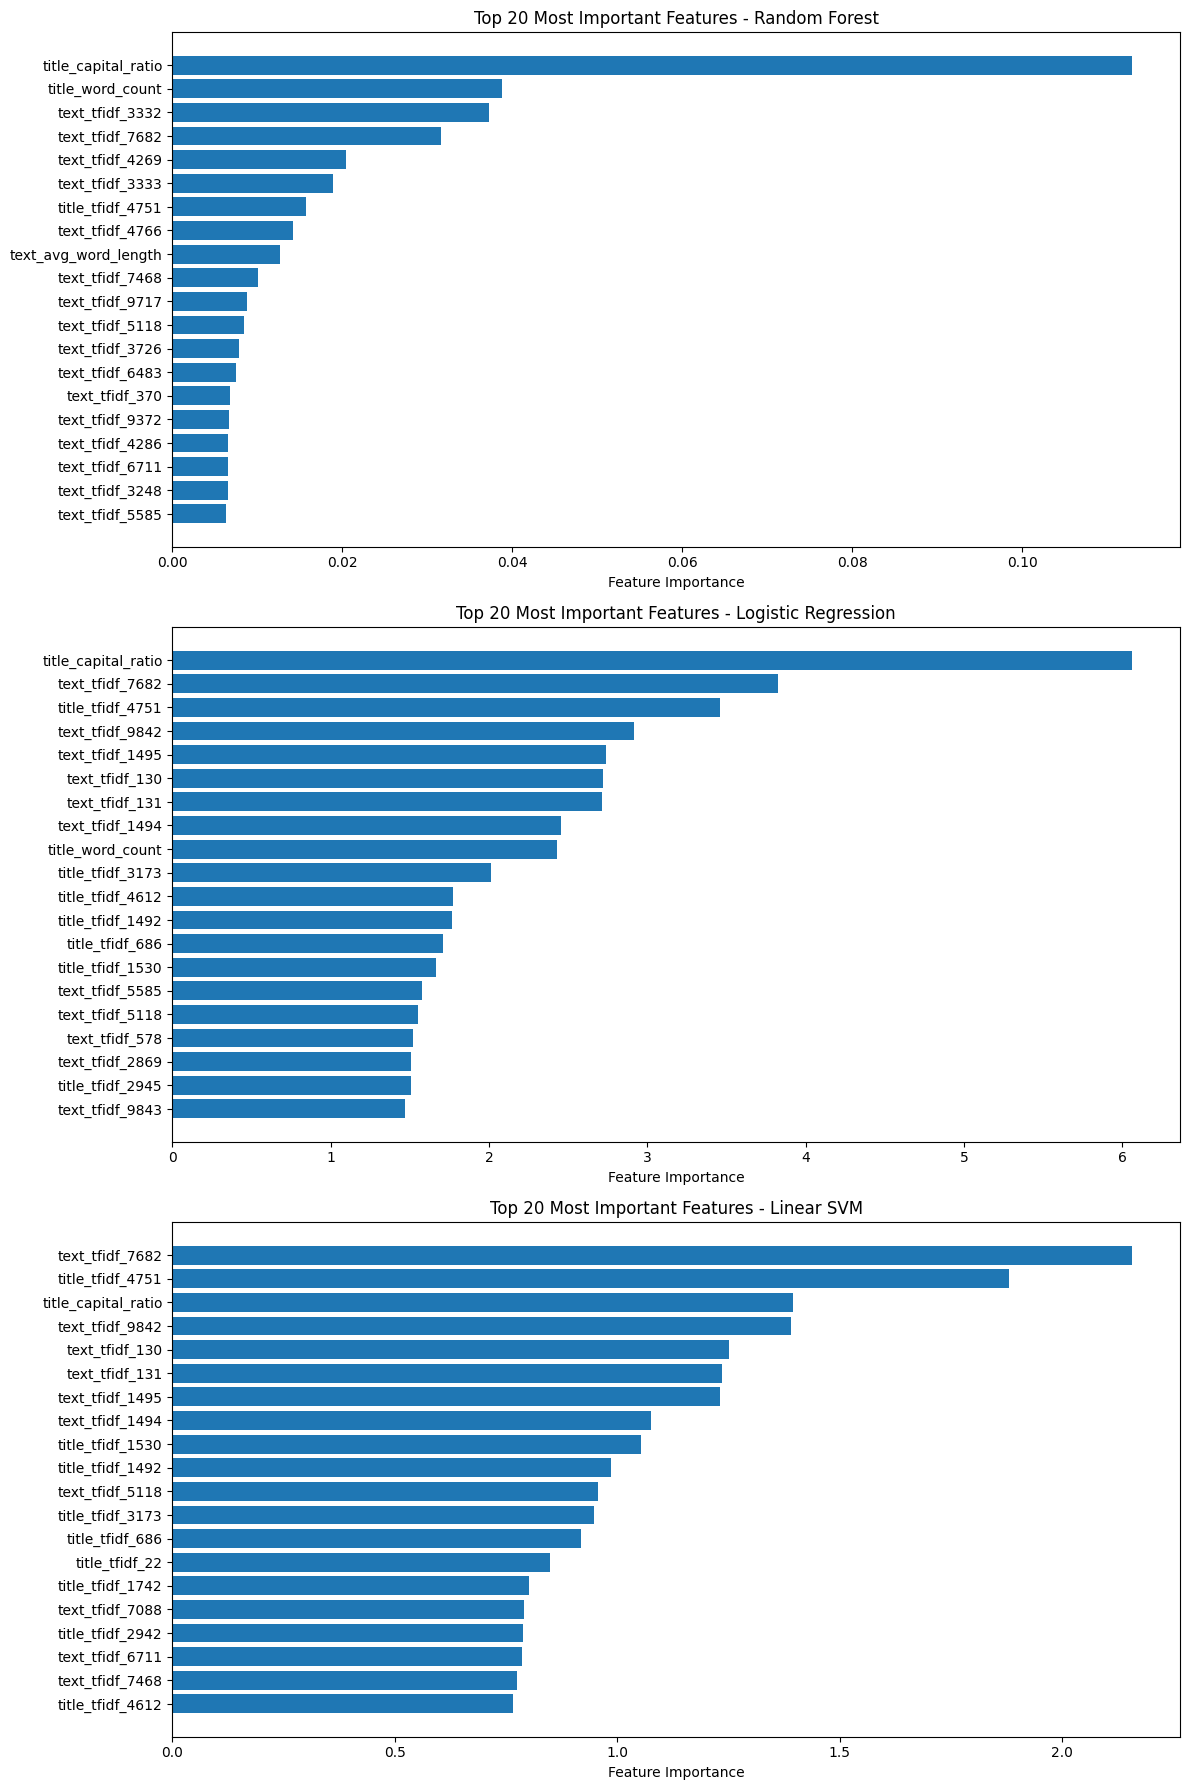

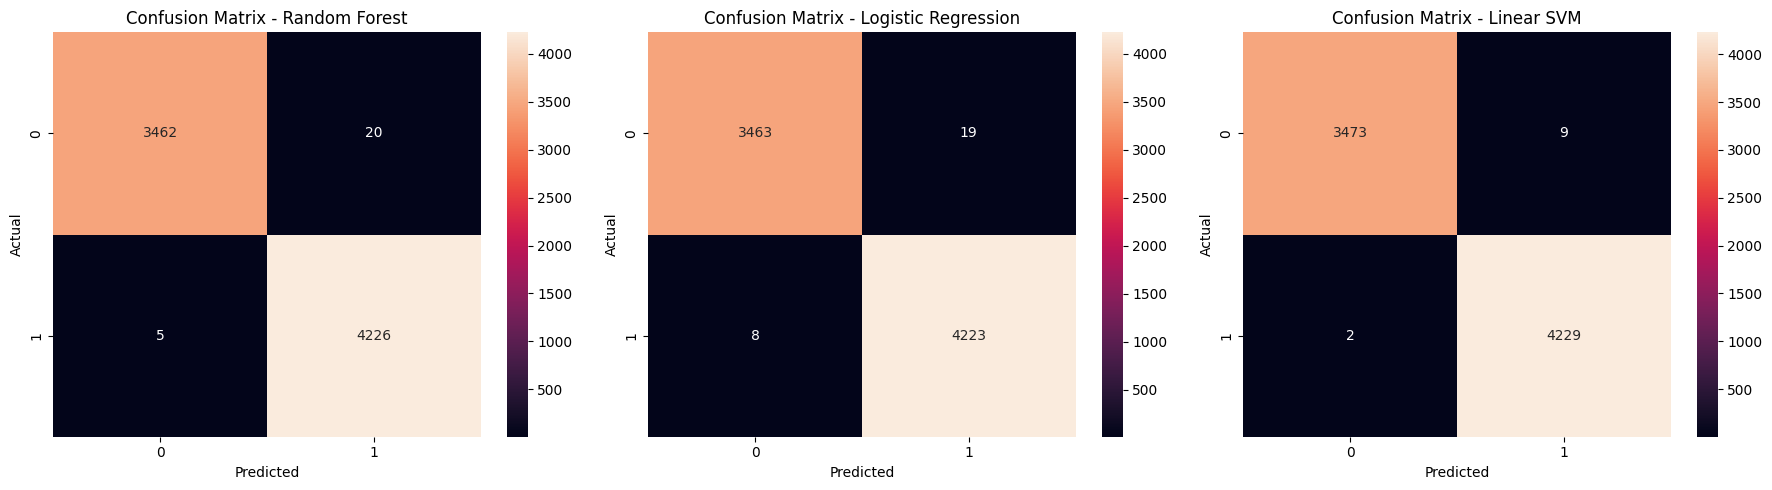

In [21]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
import re

class NewsFeatureEngineering:
    def __init__(self,
                 max_title_features: int = 5000,
                 max_text_features: int = 10000,
                 ngram_range: Tuple[int, int] = (1, 2)):
        self.max_title_features = max_title_features
        self.max_text_features = max_text_features
        self.ngram_range = ngram_range

        self.title_vectorizer = TfidfVectorizer(
            max_features=max_title_features,
            ngram_range=ngram_range,
            stop_words='english',
            strip_accents='unicode',
            min_df=2
        )

        self.text_vectorizer = TfidfVectorizer(
            max_features=max_text_features,
            ngram_range=ngram_range,
            stop_words='english',
            strip_accents='unicode',
            min_df=2
        )

        self.scaler = StandardScaler()

    def extract_statistical_features(self, text: str) -> dict:
        sentences = len(re.split(r'[.!?]+', text))
        words = text.split()
        word_count = len(words)
        avg_word_length = np.mean([len(word) for word in words]) if words else 0
        capital_ratio = sum(1 for c in text if c.isupper()) / len(text) if text else 0
        punct_ratio = sum(1 for c in text if c in '.,!?;:') / len(text) if text else 0

        return {
            'sentence_count': sentences,
            'word_count': word_count,
            'avg_word_length': avg_word_length,
            'capital_ratio': capital_ratio,
            'punct_ratio': punct_ratio
        }

    def create_feature_matrix(self, df: pd.DataFrame) -> Tuple[np.ndarray, List[str]]:
        print("Extracting TF-IDF features from titles...")
        title_tfidf = self.title_vectorizer.fit_transform(df['title'])

        print("Extracting TF-IDF features from text...")
        text_tfidf = self.text_vectorizer.fit_transform(df['text'])

        print("Extracting statistical features...")
        title_stats = pd.DataFrame(df['title'].apply(self.extract_statistical_features).tolist())
        text_stats = pd.DataFrame(df['text'].apply(self.extract_statistical_features).tolist())

        title_stats.columns = [f'title_{col}' for col in title_stats.columns]
        text_stats.columns = [f'text_{col}' for col in text_stats.columns]

        stats_features = pd.concat([title_stats, text_stats], axis=1)
        scaled_stats = self.scaler.fit_transform(stats_features)

        print("Combining features...")
        feature_matrix = np.hstack([
            title_tfidf.toarray(),
            text_tfidf.toarray(),
            scaled_stats
        ])

        feature_names = (
            [f'title_tfidf_{i}' for i in range(title_tfidf.shape[1])] +
            [f'text_tfidf_{i}' for i in range(text_tfidf.shape[1])] +
            list(stats_features.columns)
        )

        return feature_matrix, feature_names

class NewsClassifier:
    def __init__(self, random_state: int = 42):
        self.random_state = random_state
        self.classifiers = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=random_state),
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=random_state),
            'Linear SVM': LinearSVC(random_state=random_state, max_iter=2000)
        }
        self.best_model = None
        self.best_score = 0
        self.feature_names = None

    def train_and_evaluate(self, X: np.ndarray, y: np.ndarray,
                          feature_names: List[str]) -> Dict:
        self.feature_names = feature_names

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=self.random_state
        )

        results = {}

        for name, clf in self.classifiers.items():
            print(f"\nTraining {name}...")

            clf.fit(X_train, y_train)

            if hasattr(clf, 'predict_proba'):
                y_pred = clf.predict_proba(X_test)[:, 1]
                y_pred_binary = (y_pred > 0.5).astype(int)
            else:
                y_pred = clf.decision_function(X_test)
                y_pred_binary = (y_pred > 0).astype(int)

            cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
            report = classification_report(y_test, y_pred_binary, output_dict=True)

            results[name] = {
                'cv_scores': cv_scores,
                'test_report': report,
                'confusion_matrix': confusion_matrix(y_test, y_pred_binary),
                'feature_importance': self.get_feature_importance(clf)
            }

            if report['accuracy'] > self.best_score:
                self.best_score = report['accuracy']
                self.best_model = clf

            print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred_binary))

        return results

    def get_feature_importance(self, model) -> np.ndarray:
        if hasattr(model, 'feature_importances_'):
            return model.feature_importances_
        elif hasattr(model, 'coef_'):
            return model.coef_[0] if len(model.coef_.shape) > 1 else model.coef_
        else:
            return np.zeros(len(self.feature_names))

    def plot_feature_importance(self, results: Dict, top_n: int = 20):
        n_models = len(results)
        fig, axes = plt.subplots(n_models, 1, figsize=(12, 6*n_models))
        if n_models == 1:
            axes = [axes]

        for ax, (name, result) in zip(axes, results.items()):
            importance = result['feature_importance']
            feature_importance = pd.DataFrame({
                'feature': self.feature_names,
                'importance': np.abs(importance)
            }).sort_values('importance', ascending=True)

            top_features = feature_importance.tail(top_n)
            ax.barh(top_features['feature'], top_features['importance'])
            ax.set_title(f'Top {top_n} Most Important Features - {name}')
            ax.set_xlabel('Feature Importance')

        plt.tight_layout()
        return fig

    def plot_confusion_matrices(self, results: Dict):
        n_models = len(results)
        fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
        if n_models == 1:
            axes = [axes]

        for ax, (name, result) in zip(axes, results.items()):
            sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', ax=ax)
            ax.set_title(f'Confusion Matrix - {name}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')

        plt.tight_layout()
        return fig

def prepare_features(true_path: str, fake_path: str) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    print("Loading datasets...")
    true_df = pd.read_csv(true_path)
    fake_df = pd.read_csv(fake_path)

    df = pd.concat([true_df, fake_df], axis=0, ignore_index=True)
    labels = np.array([1] * len(true_df) + [0] * len(fake_df))

    feature_engineer = NewsFeatureEngineering()
    X, feature_names = feature_engineer.create_feature_matrix(df)

    return X, labels, feature_names

def main():
    true_path = 'processed_true.csv'
    fake_path = 'processed_fake.csv'

    print("Preparing features...")
    X, y, feature_names = prepare_features(true_path, fake_path)

    print(f"\nFeature matrix shape: {X.shape}")
    print(f"Number of true news: {sum(y == 1)}")
    print(f"Number of fake news: {sum(y == 0)}")

    classifier = NewsClassifier()
    results = classifier.train_and_evaluate(X, y, feature_names)

    classifier.plot_feature_importance(results)
    classifier.plot_confusion_matrices(results)
    plt.show()

if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple

class ContentFeatureEngineering:
    def __init__(self,
                 max_title_features: int = 5000,
                 max_text_features: int = 10000,
                 ngram_range: Tuple[int, int] = (1, 3)):  # Increased n-gram range for better content capture
        self.max_title_features = max_title_features
        self.max_text_features = max_text_features
        self.ngram_range = ngram_range

        # Configure TF-IDF vectorizers for semantic content
        self.title_vectorizer = TfidfVectorizer(
            max_features=max_title_features,
            ngram_range=ngram_range,
            stop_words='english',
            strip_accents='unicode',
            min_df=2,
            max_df=0.95  # Remove very common terms
        )

        self.text_vectorizer = TfidfVectorizer(
            max_features=max_text_features,
            ngram_range=ngram_range,
            stop_words='english',
            strip_accents='unicode',
            min_df=2,
            max_df=0.95
        )

    def extract_semantic_features(self, text: str) -> dict:
        """Extract content-based features without relying on formatting"""
        words = text.split()

        # Semantic richness (unique words ratio)
        unique_words = len(set(words))
        total_words = len(words)
        vocabulary_richness = unique_words / total_words if total_words > 0 else 0

        # Average word complexity (length of words)
        avg_word_complexity = np.mean([len(word) for word in words]) if words else 0

        return {
            'vocabulary_richness': vocabulary_richness,
            'avg_word_complexity': avg_word_complexity
        }

    def create_feature_matrix(self, df: pd.DataFrame) -> Tuple[np.ndarray, List[str]]:
        """Create content-focused feature matrix"""
        print("Extracting TF-IDF features from titles...")
        title_tfidf = self.title_vectorizer.fit_transform(df['title'])

        print("Extracting TF-IDF features from text...")
        text_tfidf = self.text_vectorizer.fit_transform(df['text'])

        print("Extracting semantic features...")
        title_stats = pd.DataFrame(df['title'].apply(self.extract_semantic_features).tolist())
        text_stats = pd.DataFrame(df['text'].apply(self.extract_semantic_features).tolist())

        title_stats.columns = [f'title_{col}' for col in title_stats.columns]
        text_stats.columns = [f'text_{col}' for col in text_stats.columns]

        stats_features = pd.concat([title_stats, text_stats], axis=1)

        print("Combining features...")
        feature_matrix = np.hstack([
            title_tfidf.toarray(),
            text_tfidf.toarray(),
            stats_features
        ])

        # Create feature names
        feature_names = (
            [f'title_tfidf_{i}' for i in range(title_tfidf.shape[1])] +
            [f'text_tfidf_{i}' for i in range(text_tfidf.shape[1])] +
            list(stats_features.columns)
        )

        return feature_matrix, feature_names

class ContentNewsClassifier:
    def __init__(self, random_state: int = 42):
        self.random_state = random_state
        self.classifiers = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=random_state),
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=random_state),
            'Linear SVM': LinearSVC(random_state=random_state, max_iter=2000)
        }
        self.best_model = None
        self.best_score = 0
        self.feature_names = None

    def train_and_evaluate(self, X: np.ndarray, y: np.ndarray,
                          feature_names: List[str]) -> Dict:
        """Train and evaluate classifiers using content features"""
        self.feature_names = feature_names

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=self.random_state
        )

        results = {}

        for name, clf in self.classifiers.items():
            print(f"\nTraining {name}...")

            clf.fit(X_train, y_train)

            if hasattr(clf, 'predict_proba'):
                y_pred = clf.predict_proba(X_test)[:, 1]
                y_pred_binary = (y_pred > 0.5).astype(int)
            else:
                y_pred = clf.decision_function(X_test)
                y_pred_binary = (y_pred > 0).astype(int)

            cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
            report = classification_report(y_test, y_pred_binary, output_dict=True)

            results[name] = {
                'cv_scores': cv_scores,
                'test_report': report,
                'confusion_matrix': confusion_matrix(y_test, y_pred_binary),
                'feature_importance': self.get_feature_importance(clf)
            }

            if report['accuracy'] > self.best_score:
                self.best_score = report['accuracy']
                self.best_model = clf

            print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred_binary))

        return results

    def get_feature_importance(self, model) -> np.ndarray:
        if hasattr(model, 'feature_importances_'):
            return model.feature_importances_
        elif hasattr(model, 'coef_'):
            return model.coef_[0] if len(model.coef_.shape) > 1 else model.coef_
        else:
            return np.zeros(len(self.feature_names))

    def plot_feature_importance(self, results: Dict, top_n: int = 20):
        n_models = len(results)
        fig, axes = plt.subplots(n_models, 1, figsize=(12, 6*n_models))
        if n_models == 1:
            axes = [axes]

        for ax, (name, result) in zip(axes, results.items()):
            importance = result['feature_importance']
            feature_importance = pd.DataFrame({
                'feature': self.feature_names,
                'importance': np.abs(importance)
            }).sort_values('importance', ascending=True)

            top_features = feature_importance.tail(top_n)
            ax.barh(top_features['feature'], top_features['importance'])
            ax.set_title(f'Top {top_n} Most Important Content Features - {name}')
            ax.set_xlabel('Feature Importance')

        plt.tight_layout()
        return fig

    def plot_confusion_matrices(self, results: Dict):
        n_models = len(results)
        fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
        if n_models == 1:
            axes = [axes]

        for ax, (name, result) in zip(axes, results.items()):
            sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', ax=ax)
            ax.set_title(f'Confusion Matrix - {name}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')

        plt.tight_layout()
        return fig

def prepare_features(true_path: str, fake_path: str) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    print("Loading datasets...")
    true_df = pd.read_csv(true_path)
    fake_df = pd.read_csv(fake_path)

    df = pd.concat([true_df, fake_df], axis=0, ignore_index=True)
    labels = np.array([1] * len(true_df) + [0] * len(fake_df))

    feature_engineer = ContentFeatureEngineering()
    X, feature_names = feature_engineer.create_feature_matrix(df)

    return X, labels, feature_names

def main():
    true_path = 'processed_true.csv'
    fake_path = 'processed_fake.csv'

    print("Preparing content-based features...")
    X, y, feature_names = prepare_features(true_path, fake_path)

    print(f"\nFeature matrix shape: {X.shape}")
    print(f"Number of true news: {sum(y == 1)}")
    print(f"Number of fake news: {sum(y == 0)}")

    classifier = ContentNewsClassifier()
    results = classifier.train_and_evaluate(X, y, feature_names)

    classifier.plot_feature_importance(results)
    classifier.plot_confusion_matrices(results)
    plt.show()

if __name__ == "__main__":
    main()

Preparing content-based features...
Loading datasets...
Extracting TF-IDF features from titles...
Extracting TF-IDF features from text...


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-fad4247bbc8a>", line 223, in <cell line: 0>
    main()
  File "<ipython-input-8-fad4247bbc8a>", line 209, in main
    X, y, feature_names = prepare_features(true_path, fake_path)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-8-fad4247bbc8a>", line 200, in prepare_features
    X, feature_names = feature_engineer.create_feature_matrix(df)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-8-fad4247bbc8a>", line 65, in create_feature_matrix
    text_tfidf = self.text_vectorizer.fit_transform(df['text'])
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py", line 2104, in fit_transform
    X = super().f

Loading datasets...

Sampled 1000 articles from each class
Original sizes - True: 21194, Fake: 17369
Balanced sizes - True: 1000, Fake: 1000

Extracting text features...

Training Random Forest...

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       200
           1       0.94      0.99      0.96       200

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400


Training Logistic Regression...

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       200
           1       0.93      0.98      0.96       200

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400


Training Linear SVM...

Classification Report:
              precis

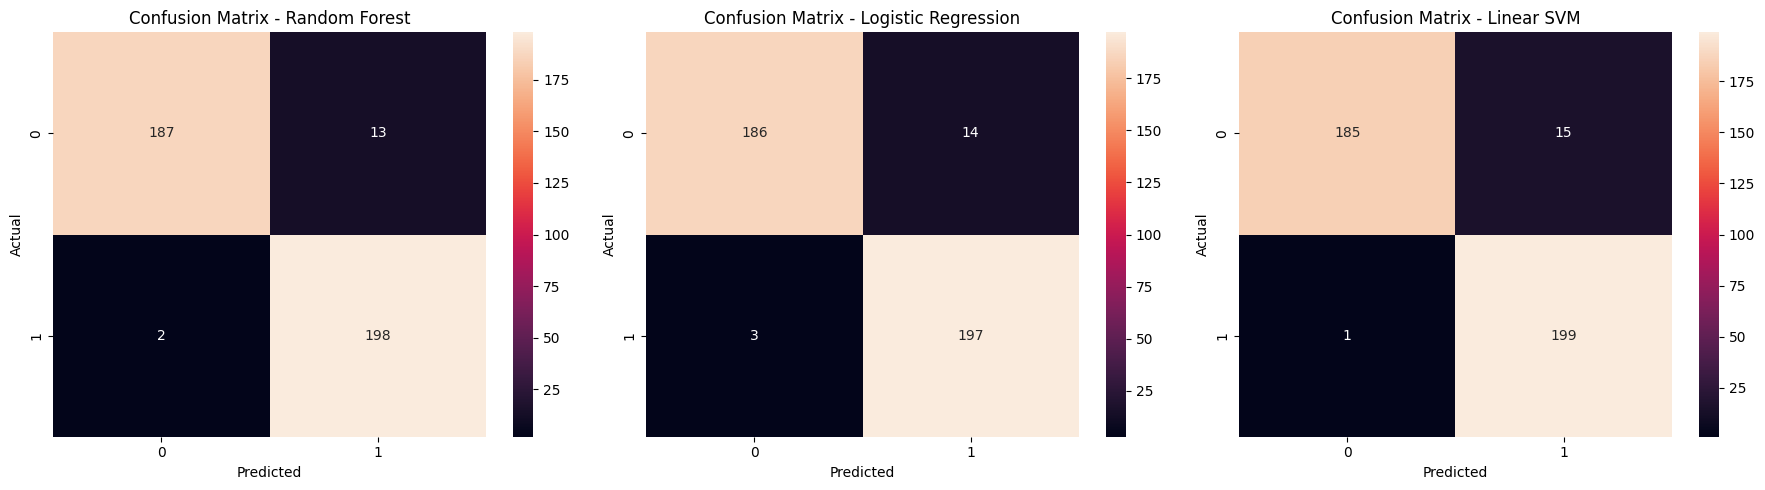

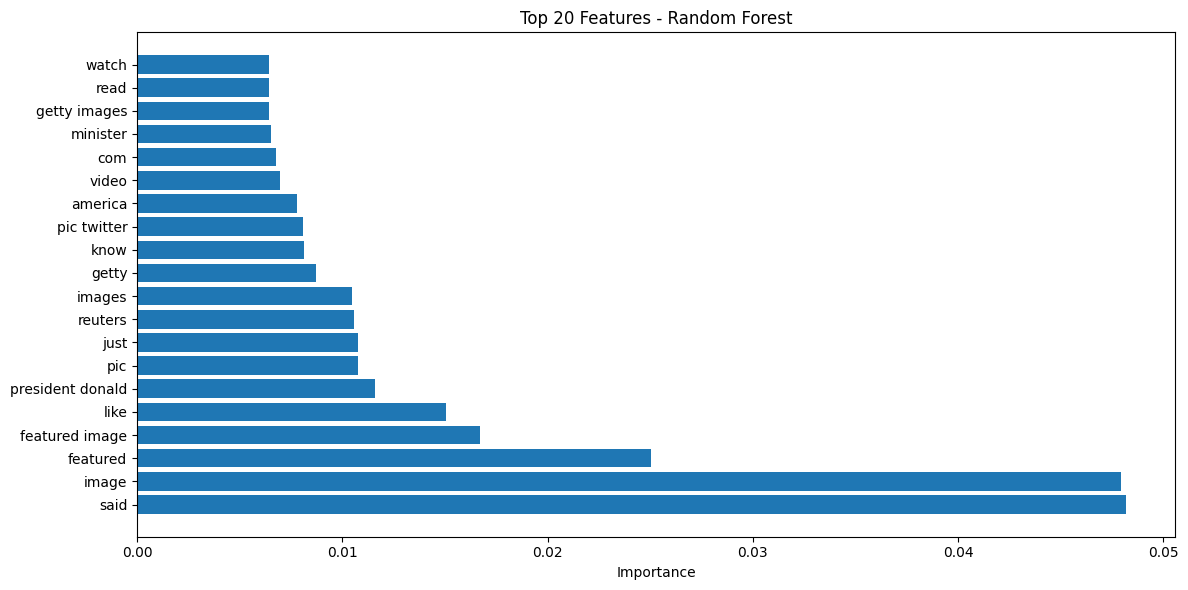

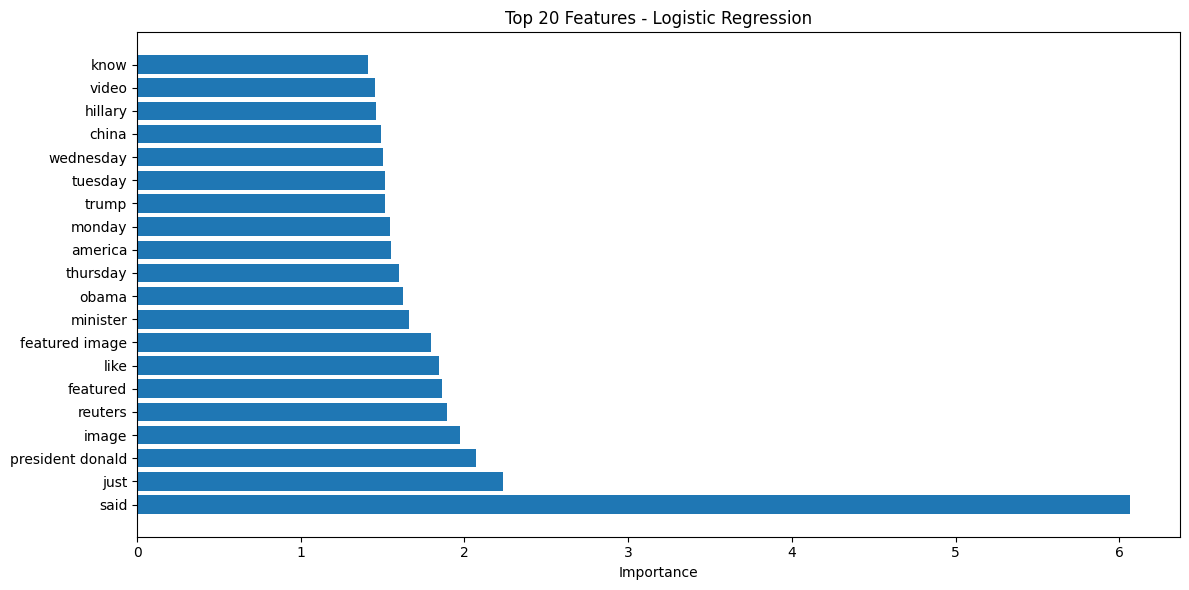

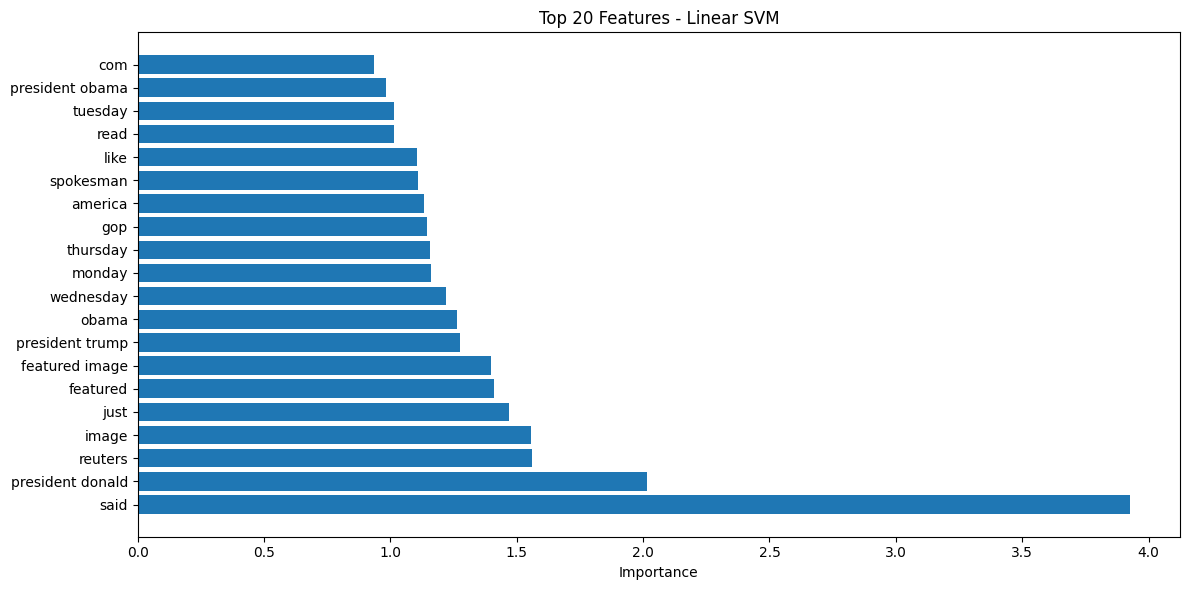

In [23]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple

def create_balanced_dataset(true_path: str, fake_path: str, sample_size: int = 1000):
    """
    Create a balanced dataset with limited samples to avoid overfitting to Reuters style

    Args:
        true_path: Path to Reuters (true) news
        fake_path: Path to fake news
        sample_size: Number of articles to sample from each class
    """
    print("Loading datasets...")
    true_df = pd.read_csv(true_path)
    fake_df = pd.read_csv(fake_path)

    # Sample equally from both datasets
    true_sample = true_df.sample(n=sample_size, random_state=42)
    fake_sample = fake_df.sample(n=sample_size, random_state=42)

    print(f"\nSampled {sample_size} articles from each class")
    print(f"Original sizes - True: {len(true_df)}, Fake: {len(fake_df)}")
    print(f"Balanced sizes - True: {len(true_sample)}, Fake: {len(fake_sample)}")

    return true_sample, fake_sample

class BalancedNewsClassifier:
    def __init__(self, max_features: int = 5000, ngram_range: Tuple[int, int] = (1, 2)):
        self.max_features = max_features
        self.ngram_range = ngram_range

        self.text_vectorizer = TfidfVectorizer(
            max_features=max_features,
            ngram_range=ngram_range,
            stop_words='english',
            strip_accents='unicode',
            min_df=2,
            max_df=0.95
        )

        self.classifiers = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
            'Linear SVM': LinearSVC(random_state=42, max_iter=2000)
        }

    def prepare_features(self, true_sample: pd.DataFrame, fake_sample: pd.DataFrame):
        """Prepare features from balanced dataset"""
        # Combine samples
        df = pd.concat([true_sample, fake_sample], axis=0, ignore_index=True)
        labels = np.array([1] * len(true_sample) + [0] * len(fake_sample))

        # Extract features
        print("\nExtracting text features...")
        features = self.text_vectorizer.fit_transform(df['text'])

        return features, labels

    def train_and_evaluate(self, X, y):
        """Train and evaluate models on balanced dataset"""
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        results = {}
        feature_names = self.text_vectorizer.get_feature_names_out()

        for name, clf in self.classifiers.items():
            print(f"\nTraining {name}...")
            clf.fit(X_train, y_train)

            # Get predictions
            if hasattr(clf, 'predict_proba'):
                y_pred = clf.predict_proba(X_test)[:, 1]
                y_pred_binary = (y_pred > 0.5).astype(int)
            else:
                y_pred = clf.decision_function(X_test)
                y_pred_binary = (y_pred > 0).astype(int)

            # Store results
            results[name] = {
                'confusion_matrix': confusion_matrix(y_test, y_pred_binary),
                'classification_report': classification_report(y_test, y_pred_binary),
                'feature_importance': self.get_feature_importance(clf, feature_names)
            }

            print("\nClassification Report:")
            print(results[name]['classification_report'])

        return results

    def get_feature_importance(self, model, feature_names):
        """Get feature importance scores"""
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importance = model.coef_[0] if len(model.coef_.shape) > 1 else model.coef_
        else:
            return None

        return pd.DataFrame({
            'feature': feature_names,
            'importance': np.abs(importance)
        }).sort_values('importance', ascending=False)

    def plot_results(self, results: Dict):
        """Plot confusion matrices and feature importance"""
        n_models = len(results)

        # Plot confusion matrices
        fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
        if n_models == 1:
            axes = [axes]

        for ax, (name, result) in zip(axes, results.items()):
            sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', ax=ax)
            ax.set_title(f'Confusion Matrix - {name}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')

        plt.tight_layout()

        # Plot top features for each model
        for name, result in results.items():
            if result['feature_importance'] is not None:
                plt.figure(figsize=(12, 6))
                top_features = result['feature_importance'].head(20)
                plt.barh(top_features['feature'], top_features['importance'])
                plt.title(f'Top 20 Features - {name}')
                plt.xlabel('Importance')
                plt.tight_layout()

        plt.show()

def main():
    # Create balanced dataset
    true_sample, fake_sample = create_balanced_dataset('processed_true.csv',
                                                      'processed_fake.csv',
                                                      sample_size=1000)

    # Train and evaluate
    classifier = BalancedNewsClassifier()
    X, y = classifier.prepare_features(true_sample, fake_sample)
    results = classifier.train_and_evaluate(X, y)
    classifier.plot_results(results)

if __name__ == "__main__":
    main()

Loading datasets...

Extracting content features (excluding source/metadata terms)...
Total stop words: 393

Feature matrix shape: (2000, 5000)

Training Random Forest...

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       200
           1       0.93      0.93      0.93       200

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400


Training Logistic Regression...

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       200
           1       0.92      0.94      0.93       200

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.92       400
weighted avg       0.93      0.93      0.92       400


Training Linear SVM...

Classification Report:
              precision    recall  f1-score   

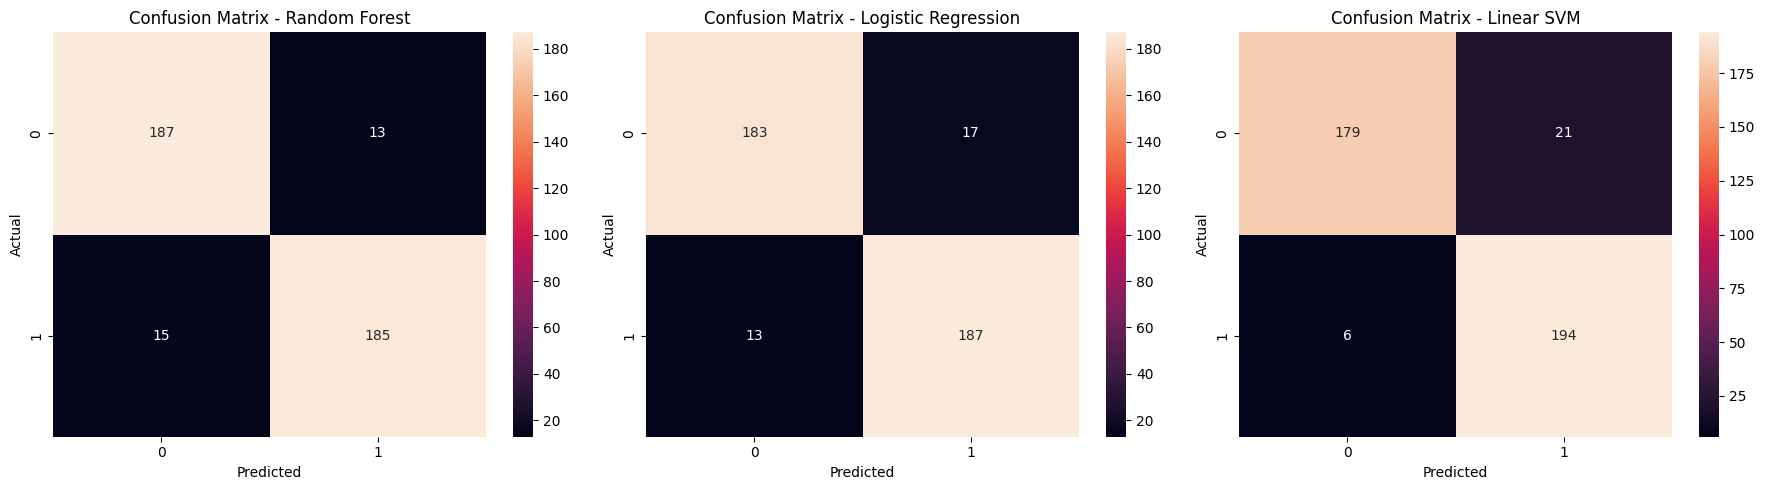

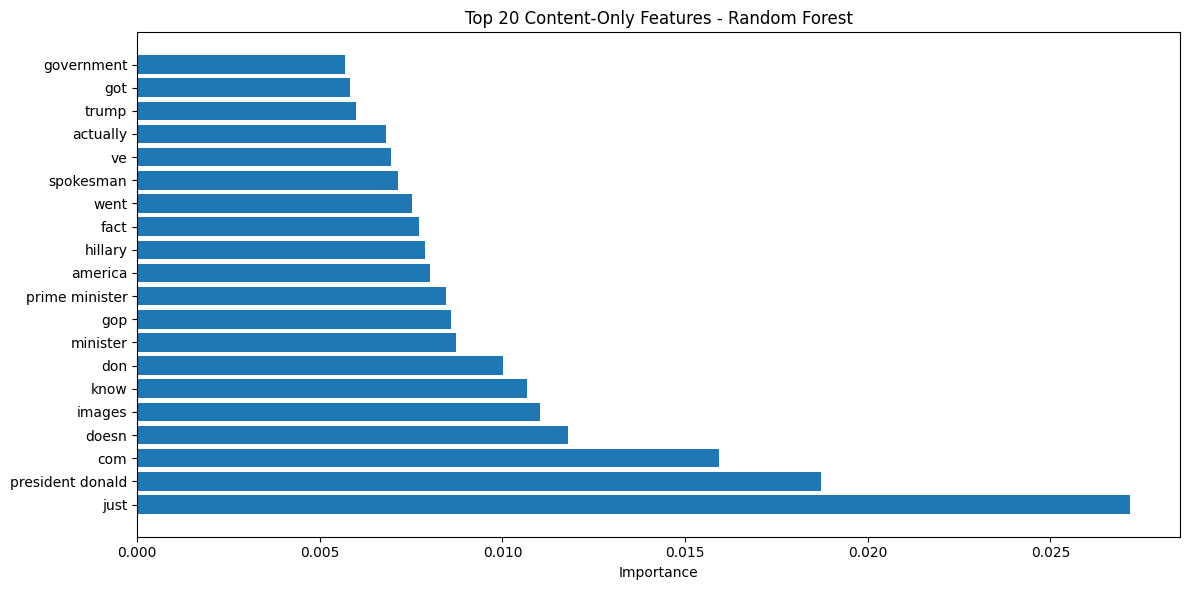

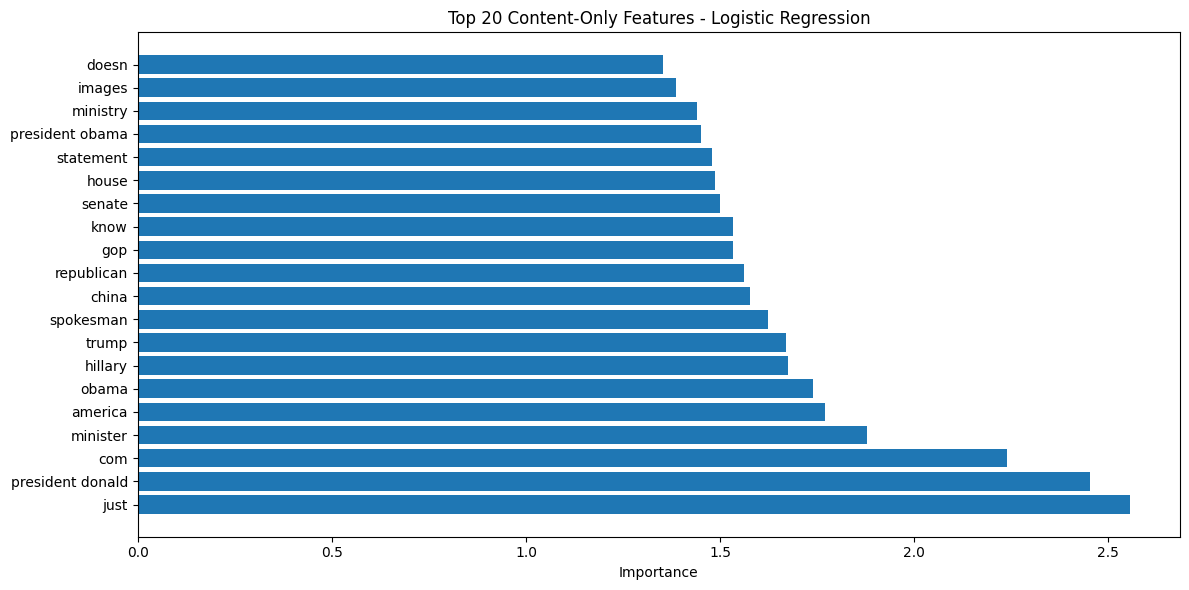

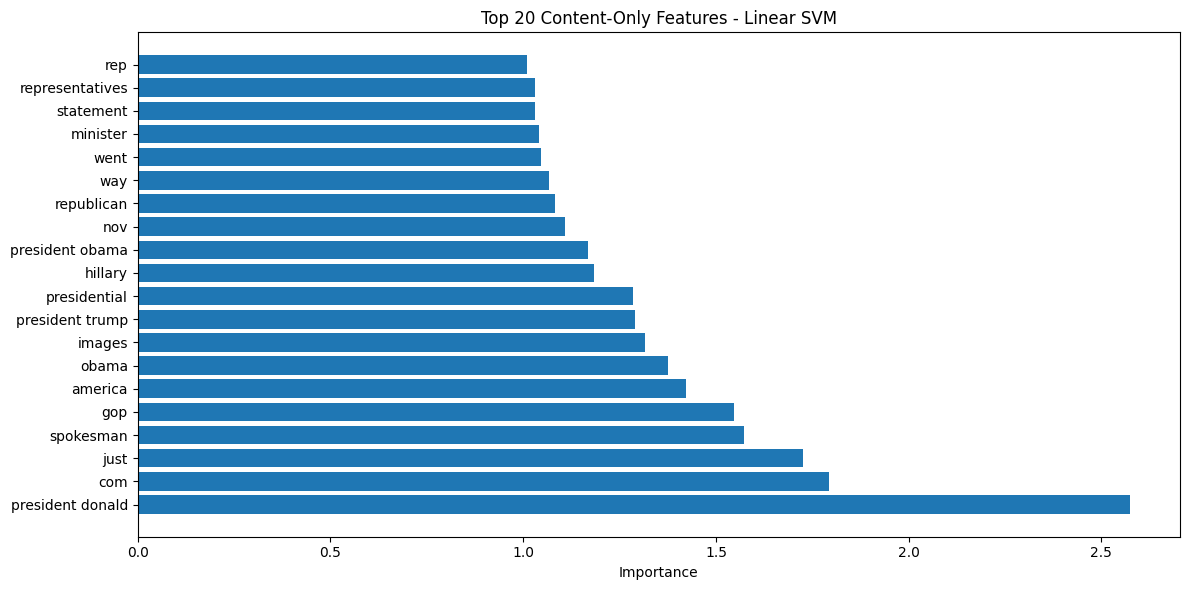

In [25]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define custom stop words for source and metadata terms
CUSTOM_STOP_WORDS = [
    # Source-specific terms
    'reuters', 'getty', 'ap', 'afp', 'bloomberg', 'associated', 'press',

    # Metadata and structural terms
    'image', 'video', 'photo', 'featured', 'exclusive', 'breaking',
    'said', 'told', 'according', 'reported', 'confirmed', 'announced',
    'shared', 'posted', 'updated', 'published', 'written', 'edited',
    'caption', 'file', 'credit', 'source', 'correspondent',

    # Common article structural words
    'read', 'click', 'watch', 'follow', 'subscribe', 'share',
    'comment', 'download', 'upload', 'link', 'url', 'website',

    # Time-related metadata
    'today', 'yesterday', 'tomorrow', 'monday', 'tuesday', 'wednesday',
    'thursday', 'friday', 'saturday', 'sunday', 'week', 'month', 'year',
    'morning', 'afternoon', 'evening', 'night',

    # Social media related
    'twitter', 'facebook', 'instagram', 'social', 'media', 'post',
    'tweet', 'like', 'follow', 'share', 'pic', 'pic.twitter',

    # Common article metadata phrases
    'contributed', 'reporting', 'editing', 'additional',

    # Add any other source/metadata terms you notice
]

# Combine with English stop words
ALL_STOP_WORDS = list(ENGLISH_STOP_WORDS) + CUSTOM_STOP_WORDS

class ContentClassifier:
    def __init__(self, sample_size=1000, random_state=42):
        self.sample_size = sample_size
        self.random_state = random_state

        # Configure vectorizer with combined stop words
        self.vectorizer = TfidfVectorizer(
            max_features=5000,
            ngram_range=(1, 2),
            stop_words=ALL_STOP_WORDS,  # Use combined list
            strip_accents='unicode',
            min_df=2,
            max_df=0.95
        )

        self.classifiers = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=random_state),
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=random_state),
            'Linear SVM': LinearSVC(random_state=random_state, max_iter=2000)
        }

    def prepare_data(self, true_path: str, fake_path: str):
        """Load and prepare balanced dataset"""
        print("Loading datasets...")
        true_df = pd.read_csv(true_path)
        fake_df = pd.read_csv(fake_path)

        # Sample equally from both datasets
        true_sample = true_df.sample(n=self.sample_size, random_state=self.random_state)
        fake_sample = fake_df.sample(n=self.sample_size, random_state=self.random_state)

        # Combine samples
        df = pd.concat([true_sample, fake_sample], axis=0, ignore_index=True)
        labels = np.array([1] * len(true_sample) + [0] * len(fake_sample))

        # Extract features
        print("\nExtracting content features (excluding source/metadata terms)...")
        print(f"Total stop words: {len(ALL_STOP_WORDS)}")
        features = self.vectorizer.fit_transform(df['text'])

        print(f"\nFeature matrix shape: {features.shape}")
        return features, labels

    def train_and_evaluate(self, X, y):
        """Train and evaluate models"""
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=self.random_state, stratify=y
        )

        results = {}
        feature_names = self.vectorizer.get_feature_names_out()

        for name, clf in self.classifiers.items():
            print(f"\nTraining {name}...")
            clf.fit(X_train, y_train)

            if hasattr(clf, 'predict_proba'):
                y_pred = clf.predict_proba(X_test)[:, 1]
                y_pred_binary = (y_pred > 0.5).astype(int)
            else:
                y_pred = clf.decision_function(X_test)
                y_pred_binary = (y_pred > 0).astype(int)

            results[name] = {
                'confusion_matrix': confusion_matrix(y_test, y_pred_binary),
                'classification_report': classification_report(y_test, y_pred_binary, output_dict=True),
                'feature_importance': self.get_feature_importance(clf, feature_names)
            }

            print("\nClassification Report:")
            print(classification_report(y_test, y_pred_binary))

        return results

    def get_feature_importance(self, model, feature_names):
        """Get feature importance scores"""
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importance = model.coef_[0] if len(model.coef_.shape) > 1 else model.coef_
        else:
            return None

        return pd.DataFrame({
            'feature': feature_names,
            'importance': np.abs(importance)
        }).sort_values('importance', ascending=False)

    def plot_results(self, results):
        """Plot confusion matrices and feature importance"""
        n_models = len(results)

        # Plot confusion matrices
        fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
        if n_models == 1:
            axes = [axes]

        for ax, (name, result) in zip(axes, results.items()):
            sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', ax=ax)
            ax.set_title(f'Confusion Matrix - {name}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')

        plt.tight_layout()

        # Plot top features for each model
        for name, result in results.items():
            if result['feature_importance'] is not None:
                plt.figure(figsize=(12, 6))
                top_features = result['feature_importance'].head(20)
                plt.barh(top_features['feature'], top_features['importance'])
                plt.title(f'Top 20 Content-Only Features - {name}')
                plt.xlabel('Importance')
                plt.tight_layout()

        plt.show()

def main():
    classifier = ContentClassifier(sample_size=1000)
    X, y = classifier.prepare_data('processed_true.csv', 'processed_fake.csv')
    results = classifier.train_and_evaluate(X, y)
    classifier.plot_results(results)

if __name__ == "__main__":
    main()

content+ temporal

Loading datasets...

Temporal Split Details:
Train period: up to 2017-03-24 00:00:00
Test period: from 2017-03-25 00:00:00

Dataset Composition:
Training True News: 6564
Training Fake News: 12743
Testing True News: 14630
Testing Fake News: 4626

Training Random Forest...

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.98      0.57      4626
           1       0.99      0.54      0.70     14630

    accuracy                           0.64     19256
   macro avg       0.69      0.76      0.63     19256
weighted avg       0.85      0.64      0.67     19256


Training Logistic Regression...

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.97      0.71      4626
           1       0.99      0.76      0.86     14630

    accuracy                           0.81     19256
   macro avg       0.78      0.87      0.79     19256
weighted avg       0.89      0.81      0.83     

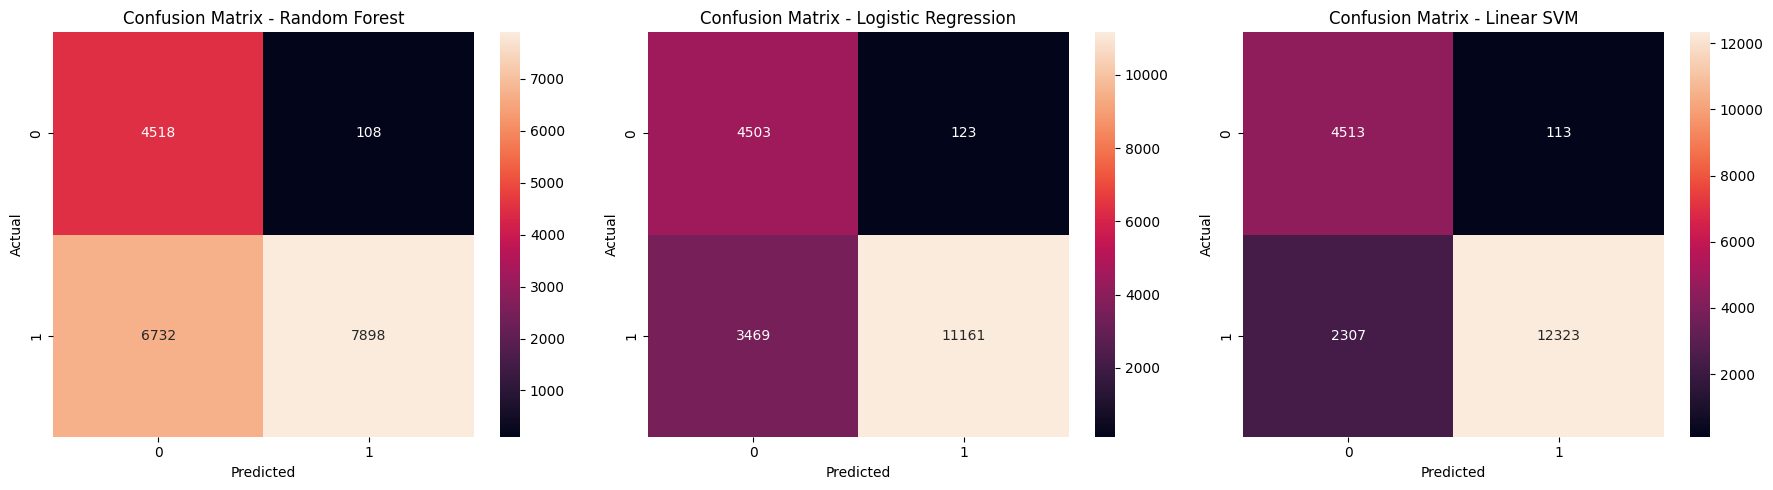

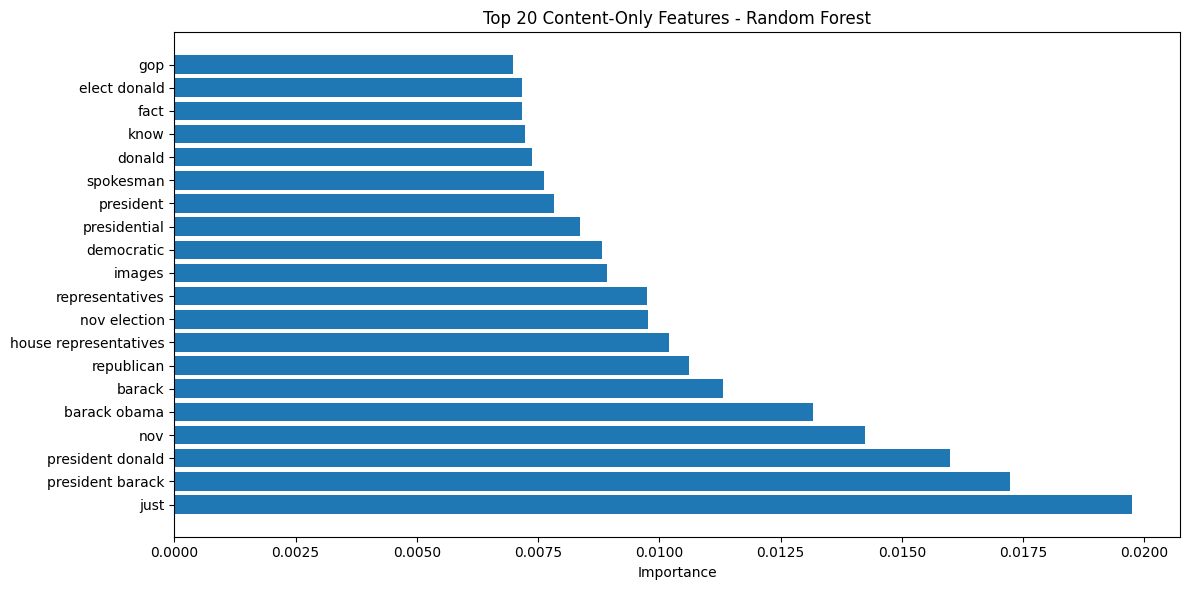

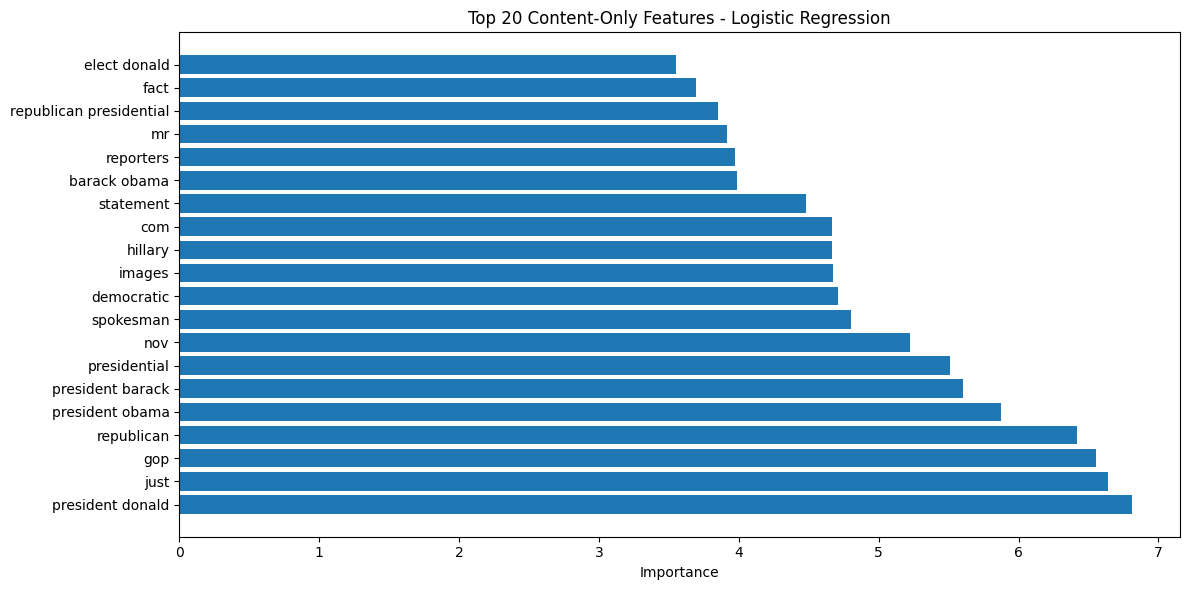

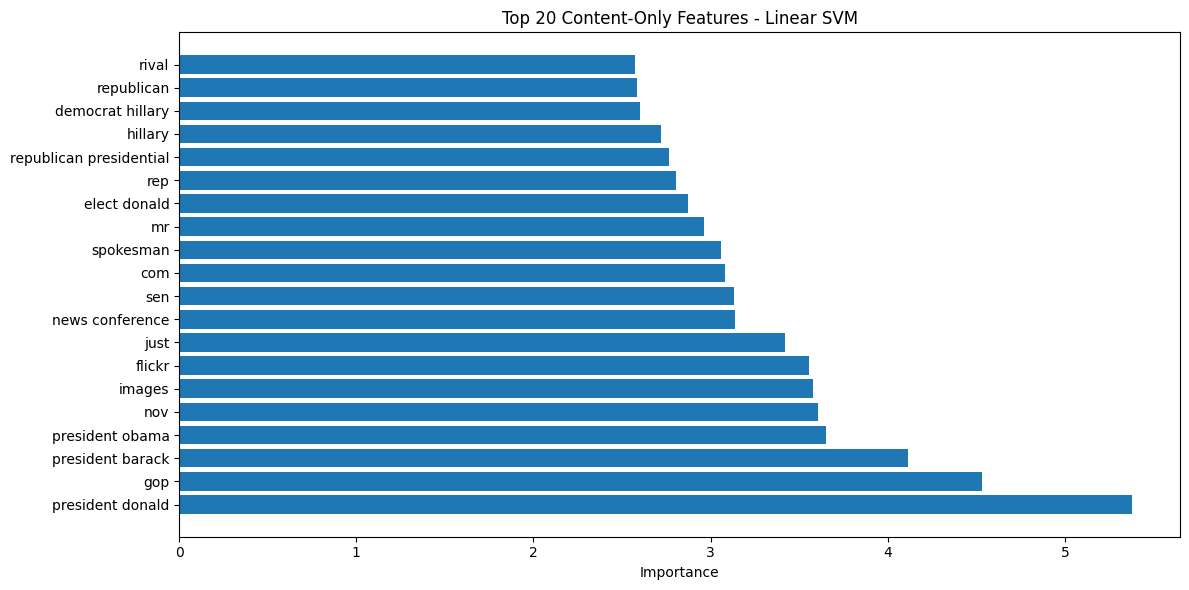

In [8]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define custom stop words for source and metadata terms
CUSTOM_STOP_WORDS = [
    # Source-specific terms
    'reuters', 'getty', 'ap', 'afp', 'bloomberg', 'associated', 'press',

    # Metadata and structural terms
    'image', 'video', 'photo', 'featured', 'exclusive', 'breaking',
    'said', 'told', 'according', 'reported', 'confirmed', 'announced',
    'shared', 'posted', 'updated', 'published', 'written', 'edited',
    'caption', 'file', 'credit', 'source', 'correspondent',

    # Common article structural words
    'read', 'click', 'watch', 'follow', 'subscribe', 'share',
    'comment', 'download', 'upload', 'link', 'url', 'website',

    # Time-related metadata
    'today', 'yesterday', 'tomorrow', 'monday', 'tuesday', 'wednesday',
    'thursday', 'friday', 'saturday', 'sunday', 'week', 'month', 'year',
    'morning', 'afternoon', 'evening', 'night',

    # Social media related
    'twitter', 'facebook', 'instagram', 'social', 'media', 'post',
    'tweet', 'like', 'follow', 'share', 'pic', 'pic.twitter',

    # Common article metadata phrases
    'contributed', 'reporting', 'editing', 'additional',

    # Add any other source/metadata terms you notice
]

# Combine with English stop words
ALL_STOP_WORDS = list(ENGLISH_STOP_WORDS) + CUSTOM_STOP_WORDS

class TemporalContentClassifier:
    def __init__(self, train_cutoff_date=None, test_start_date=None, random_state=42):
        """
        Initialize Temporal Content Classifier

        Args:
            train_cutoff_date (str or datetime, optional):
                Date before which articles will be used for training.
                If None, defaults to the median date of the entire dataset.
            test_start_date (str or datetime, optional):
                Date from which articles will be used for testing.
                If None, it will be set after the train_cutoff_date.
            random_state (int): Random seed for reproducibility
        """
        self.train_cutoff_date = train_cutoff_date
        self.test_start_date = test_start_date
        self.random_state = random_state

        # Configure vectorizer with combined stop words
        self.vectorizer = TfidfVectorizer(
            max_features=5000,
            ngram_range=(1, 2),
            stop_words=ALL_STOP_WORDS,
            strip_accents='unicode',
            min_df=2,
            max_df=0.95
        )

        self.classifiers = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=random_state),
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=random_state),
            'Linear SVM': LinearSVC(random_state=random_state, max_iter=2000)
        }

    def prepare_temporal_data(self, true_path: str, fake_path: str, date_column='date'):
        """
        Prepare dataset using temporal splitting

        Args:
            true_path (str): Path to true news CSV
            fake_path (str): Path to fake news CSV
            date_column (str): Name of the date column in the dataframes

        Returns:
            tuple: Features and labels for training and testing
        """
        print("Loading datasets...")
        # Read datasets
        true_df = pd.read_csv(true_path, parse_dates=[date_column])
        fake_df = pd.read_csv(fake_path, parse_dates=[date_column])

        # Combine datasets
        true_df['label'] = 1
        fake_df['label'] = 0
        combined_df = pd.concat([true_df, fake_df], ignore_index=True)

        # Sort by date
        combined_df.sort_values(by=date_column, inplace=True)

        # Determine cutoff dates if not provided
        if self.train_cutoff_date is None:
            self.train_cutoff_date = combined_df[date_column].quantile(0.5)

        if self.test_start_date is None:
            self.test_start_date = self.train_cutoff_date + pd.Timedelta(days=1)

        # Split into training and testing sets based on date
        train_df = combined_df[combined_df[date_column] <= self.train_cutoff_date]
        test_df = combined_df[combined_df[date_column] >= self.test_start_date]

        print("\nTemporal Split Details:")
        print(f"Train period: up to {self.train_cutoff_date}")
        print(f"Test period: from {self.test_start_date}")

        # Stratified sampling within training and testing sets
        train_true = train_df[train_df['label'] == 1]
        train_fake = train_df[train_df['label'] == 0]
        test_true = test_df[test_df['label'] == 1]
        test_fake = test_df[test_df['label'] == 0]

        print("\nDataset Composition:")
        print(f"Training True News: {len(train_true)}")
        print(f"Training Fake News: {len(train_fake)}")
        print(f"Testing True News: {len(test_true)}")
        print(f"Testing Fake News: {len(test_fake)}")

        # Extract features
        X_train = self.vectorizer.fit_transform(train_df['text'])
        y_train = train_df['label'].values

        X_test = self.vectorizer.transform(test_df['text'])
        y_test = test_df['label'].values

        return X_train, X_test, y_train, y_test

    def train_and_evaluate(self, X_train, X_test, y_train, y_test):
        """
        Train and evaluate models using temporal split

        Args:
            X_train (sparse matrix): Training feature matrix
            X_test (sparse matrix): Testing feature matrix
            y_train (array): Training labels
            y_test (array): Testing labels

        Returns:
            dict: Results for each classifier
        """
        results = {}
        feature_names = self.vectorizer.get_feature_names_out()

        for name, clf in self.classifiers.items():
            print(f"\nTraining {name}...")
            clf.fit(X_train, y_train)

            if hasattr(clf, 'predict_proba'):
                y_pred = clf.predict_proba(X_test)[:, 1]
                y_pred_binary = (y_pred > 0.5).astype(int)
            else:
                y_pred = clf.decision_function(X_test)
                y_pred_binary = (y_pred > 0).astype(int)

            results[name] = {
                'confusion_matrix': confusion_matrix(y_test, y_pred_binary),
                'classification_report': classification_report(y_test, y_pred_binary, output_dict=True),
                'feature_importance': self.get_feature_importance(clf, feature_names)
            }

            print("\nClassification Report:")
            print(classification_report(y_test, y_pred_binary))

        return results

    def get_feature_importance(self, model, feature_names):
        """Get feature importance scores"""
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importance = model.coef_[0] if len(model.coef_.shape) > 1 else model.coef_
        else:
            return None

        return pd.DataFrame({
            'feature': feature_names,
            'importance': np.abs(importance)
        }).sort_values('importance', ascending=False)

    def plot_results(self, results):
        """Plot confusion matrices and feature importance"""
        n_models = len(results)

        # Plot confusion matrices
        fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
        if n_models == 1:
            axes = [axes]

        for ax, (name, result) in zip(axes, results.items()):
            sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', ax=ax)
            ax.set_title(f'Confusion Matrix - {name}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')

        plt.tight_layout()

        # Plot top features for each model
        for name, result in results.items():
            if result['feature_importance'] is not None:
                plt.figure(figsize=(12, 6))
                top_features = result['feature_importance'].head(20)
                plt.barh(top_features['feature'], top_features['importance'])
                plt.title(f'Top 20 Content-Only Features - {name}')
                plt.xlabel('Importance')
                plt.tight_layout()

        plt.show()

def main():
    # Example usage with custom temporal split
    # You can adjust the dates or let them be auto-determined
    classifier = TemporalContentClassifier(
        # Optionally specify exact dates, e.g.:
        # train_cutoff_date='2022-12-31',
        # test_start_date='2023-01-01'
    )

    # Prepare data with temporal splitting
    X_train, X_test, y_train, y_test = classifier.prepare_temporal_data(
        'processed_true.csv',
        'processed_fake.csv',
        date_column='date'
    )

    # Train and evaluate
    results = classifier.train_and_evaluate(X_train, X_test, y_train, y_test)

    # Plot results
    classifier.plot_results(results)

if __name__ == "__main__":
    main()

BERT

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda
Loading datasets...

Temporal Split Details:
Train period: up to 2017-03-24 00:00:00
Test period: from 2017-03-25 00:00:00

Dataset Composition:
Training True News: 6564
Training Fake News: 12743
Testing True News: 14630
Testing Fake News: 4626

Epoch 1/3
Average training loss: 0.0202

Epoch 2/3
Average training loss: 0.0009

Epoch 3/3
Average training loss: 0.0000


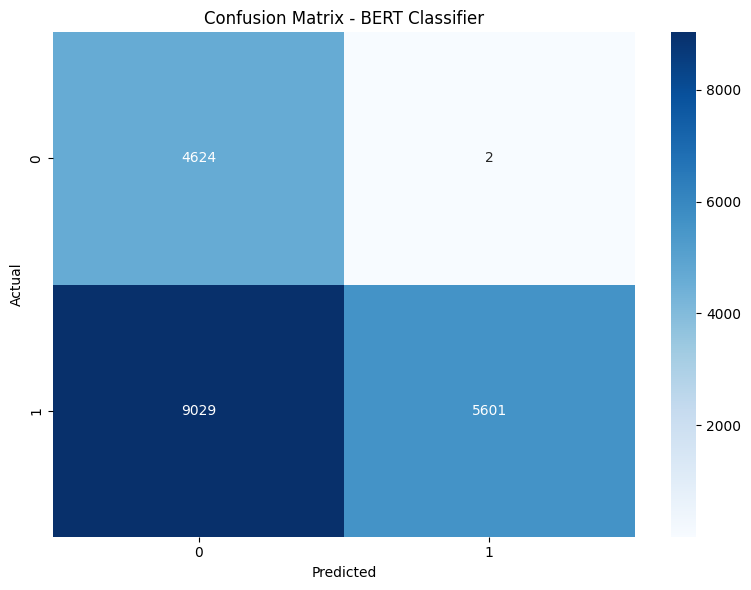


Classification Report:


KeyError: 'true_labels'

In [9]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class TemporalBertClassifier:
    def __init__(self,
                 model_name='bert-base-uncased',
                 max_length=512,
                 train_cutoff_date=None,
                 test_start_date=None,
                 batch_size=16,
                 learning_rate=2e-5,
                 epochs=3,
                 random_state=42):
        """
        Initialize BERT-based Temporal News Classifier

        Args:
            model_name (str): Pre-trained BERT model to use
            max_length (int): Maximum sequence length
            train_cutoff_date (str or datetime): Date for training data cutoff
            test_start_date (str or datetime): Date for test data start
            batch_size (int): Training batch size
            learning_rate (float): Learning rate for fine-tuning
            epochs (int): Number of training epochs
            random_state (int): Random seed for reproducibility
        """
        # Set random seeds
        self.random_state = random_state
        np.random.seed(random_state)
        torch.manual_seed(random_state)

        # Model and tokenizer
        self.model_name = model_name
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=2,  # Binary classification
            output_attentions=False,
            output_hidden_states=False
        )

        # Training hyperparameters
        self.max_length = max_length
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs

        # Temporal split parameters
        self.train_cutoff_date = train_cutoff_date
        self.test_start_date = test_start_date

        # Device configuration
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        self.model.to(self.device)

    class NewsDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, max_length):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_length = max_length

        def __len__(self):
            return len(self.texts)

        def __getitem__(self, idx):
            # Tokenize text
            encoding = self.tokenizer(
                self.texts[idx],
                return_tensors='pt',
                max_length=self.max_length,
                padding='max_length',
                truncation=True
            )

            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'labels': torch.tensor(self.labels[idx], dtype=torch.long)
            }

    def prepare_temporal_data(self, true_path, fake_path, date_column='date'):
        """
        Prepare dataset using temporal splitting

        Args:
            true_path (str): Path to true news CSV
            fake_path (str): Path to fake news CSV
            date_column (str): Name of the date column in the dataframes

        Returns:
            tuple: Training and testing datasets
        """
        print("Loading datasets...")
        # Read datasets
        true_df = pd.read_csv(true_path, parse_dates=[date_column])
        fake_df = pd.read_csv(fake_path, parse_dates=[date_column])

        # Combine and label datasets
        true_df['label'] = 1
        fake_df['label'] = 0
        combined_df = pd.concat([true_df, fake_df], ignore_index=True)

        # Sort by date
        combined_df.sort_values(by=date_column, inplace=True)

        # Determine cutoff dates if not provided
        if self.train_cutoff_date is None:
            self.train_cutoff_date = combined_df[date_column].quantile(0.5)

        if self.test_start_date is None:
            self.test_start_date = self.train_cutoff_date + pd.Timedelta(days=1)

        # Split into training and testing sets based on date
        train_df = combined_df[combined_df[date_column] <= self.train_cutoff_date]
        test_df = combined_df[combined_df[date_column] >= self.test_start_date]

        print("\nTemporal Split Details:")
        print(f"Train period: up to {self.train_cutoff_date}")
        print(f"Test period: from {self.test_start_date}")

        print("\nDataset Composition:")
        print(f"Training True News: {len(train_df[train_df['label'] == 1])}")
        print(f"Training Fake News: {len(train_df[train_df['label'] == 0])}")
        print(f"Testing True News: {len(test_df[test_df['label'] == 1])}")
        print(f"Testing Fake News: {len(test_df[test_df['label'] == 0])}")

        # Create datasets
        train_dataset = self.NewsDataset(
            texts=train_df['text'].tolist(),
            labels=train_df['label'].tolist(),
            tokenizer=self.tokenizer,
            max_length=self.max_length
        )

        test_dataset = self.NewsDataset(
            texts=test_df['text'].tolist(),
            labels=test_df['label'].tolist(),
            tokenizer=self.tokenizer,
            max_length=self.max_length
        )

        return train_dataset, test_dataset

    def train(self, train_dataset):
        """
        Train BERT model

        Args:
            train_dataset (Dataset): Training dataset
        """
        # Create data loader
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True
        )

        # Prepare optimizer and schedule
        optimizer = AdamW(
            self.model.parameters(),
            lr=self.learning_rate
        )

        total_steps = len(train_loader) * self.epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )

        # Training loop
        self.model.train()
        for epoch in range(self.epochs):
            total_loss = 0
            print(f"\nEpoch {epoch+1}/{self.epochs}")

            for batch in train_loader:
                # Move batch to device
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                # Zero gradients
                self.model.zero_grad()

                # Forward pass
                outputs = self.model(
                    input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                loss = outputs.loss
                total_loss += loss.item()

                # Backward pass
                loss.backward()

                # Clip gradients
                torch.nn.utils.clip_grad_norm_(
                    self.model.parameters(),
                    1.0
                )

                # Update parameters
                optimizer.step()
                scheduler.step()

            avg_train_loss = total_loss / len(train_loader)
            print(f"Average training loss: {avg_train_loss:.4f}")

    def evaluate(self, test_dataset):
        """
        Evaluate the model on test dataset

        Args:
            test_dataset (Dataset): Testing dataset

        Returns:
            dict: Evaluation metrics
        """
        # Create data loader
        test_loader = DataLoader(
            test_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )

        # Evaluation mode
        self.model.eval()

        # Prediction containers
        true_labels = []
        predictions = []

        # Disable gradient calculations
        with torch.no_grad():
            for batch in test_loader:
                # Move batch to device
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].cpu().numpy()

                # Forward pass
                outputs = self.model(
                    input_ids,
                    attention_mask=attention_mask
                )

                # Get predictions
                _, preds = torch.max(outputs.logits, dim=1)
                preds = preds.cpu().numpy()

                # Collect results
                true_labels.extend(labels)
                predictions.extend(preds)

        # Generate classification report
        report = classification_report(
            true_labels,
            predictions,
            output_dict=True
        )

        # Confusion matrix
        cm = confusion_matrix(true_labels, predictions)

        # Visualize results
        self._plot_results(cm, report)

        return {
            'classification_report': report,
            'confusion_matrix': cm
        }

    def _plot_results(self, cm, report):
        """
        Plot confusion matrix and performance metrics

        Args:
            cm (array): Confusion matrix
            report (dict): Classification report
        """
        # Confusion Matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix - BERT Classifier')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()

        # Print detailed report
        print("\nClassification Report:")
        print(classification_report(
            list(report['true_labels']),
            list(report['predictions'])
        ))

def main():
    # Initialize BERT Classifier
    bert_classifier = TemporalBertClassifier(
        model_name='bert-base-uncased',
        max_length=512,
        batch_size=16,
        learning_rate=2e-5,
        epochs=3
    )

    # Prepare temporal data
    train_dataset, test_dataset = bert_classifier.prepare_temporal_data(
        'processed_true.csv',
        'processed_fake.csv',
        date_column='date'
    )

    # Train the model
    bert_classifier.train(train_dataset)

    # Evaluate the model
    results = bert_classifier.evaluate(test_dataset)

if __name__ == "__main__":
    main()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda
Loading datasets...

Temporal Split Details:
Train period: up to 2017-03-24 00:00:00
Test period: from 2017-03-25 00:00:00

Dataset Composition:
Training True News: 6564
Training Fake News: 12743
Testing True News: 14630
Testing Fake News: 4626

--- Cross-Validation ---

Cross-Validation Fold 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3
Validation loss: 0.0045
Average training loss: 0.0253

Epoch 2/3
Validation loss: 0.0017
Average training loss: 0.0018

Epoch 3/3
Validation loss: 0.0038
Average training loss: 0.0004


<ipython-input-6-8fa15b1d254d>:351: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load('best_model.pt'))



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2549
           1       1.00      1.00      1.00      1313

    accuracy                           1.00      3862
   macro avg       1.00      1.00      1.00      3862
weighted avg       1.00      1.00      1.00      3862



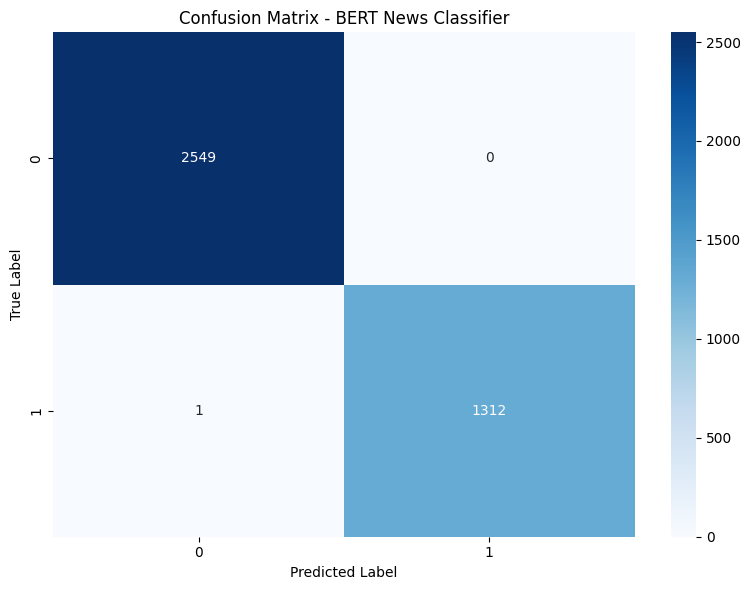


Cross-Validation Fold 2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3
Validation loss: 0.0099
Average training loss: 0.0228

Epoch 2/3
Validation loss: 0.0147
Average training loss: 0.0013

Epoch 3/3
Validation loss: 0.0037
Average training loss: 0.0008


<ipython-input-6-8fa15b1d254d>:351: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load('best_model.pt'))



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2549
           1       1.00      1.00      1.00      1313

    accuracy                           1.00      3862
   macro avg       1.00      1.00      1.00      3862
weighted avg       1.00      1.00      1.00      3862



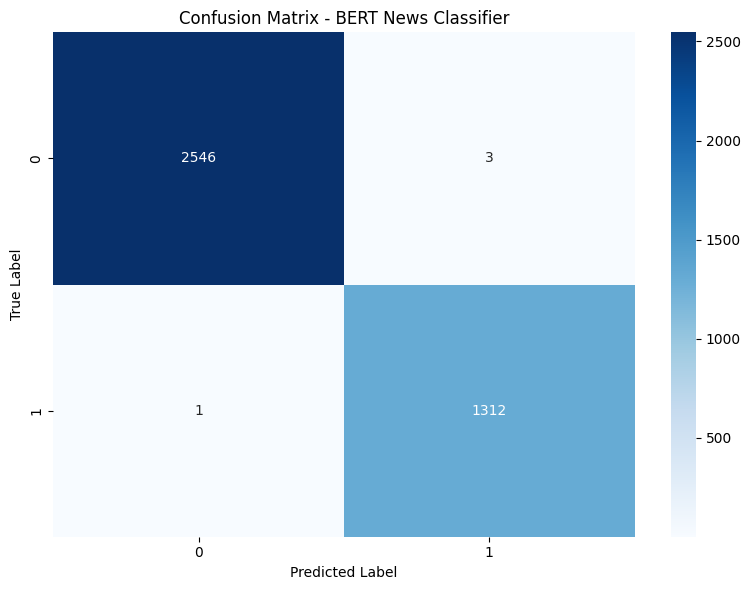


Cross-Validation Fold 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3
Validation loss: 0.0075
Average training loss: 0.0220

Epoch 2/3
Validation loss: 0.0000
Average training loss: 0.0014

Epoch 3/3
Validation loss: 0.0013
Average training loss: 0.0004


<ipython-input-6-8fa15b1d254d>:351: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load('best_model.pt'))



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2549
           1       1.00      1.00      1.00      1312

    accuracy                           1.00      3861
   macro avg       1.00      1.00      1.00      3861
weighted avg       1.00      1.00      1.00      3861



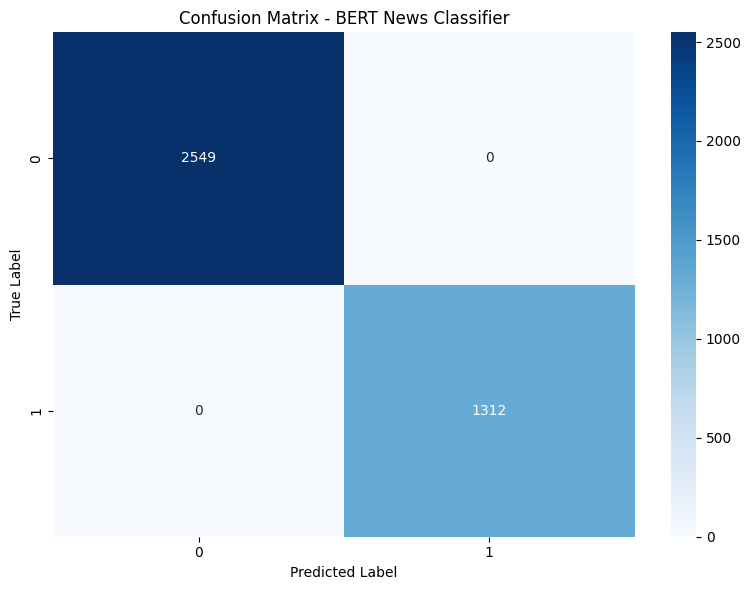


Cross-Validation Fold 4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3
Validation loss: 0.0051
Average training loss: 0.0169

Epoch 2/3
Validation loss: 0.0066
Average training loss: 0.0017

Epoch 3/3
Validation loss: 0.0043
Average training loss: 0.0000


<ipython-input-6-8fa15b1d254d>:351: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load('best_model.pt'))



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2548
           1       1.00      1.00      1.00      1313

    accuracy                           1.00      3861
   macro avg       1.00      1.00      1.00      3861
weighted avg       1.00      1.00      1.00      3861



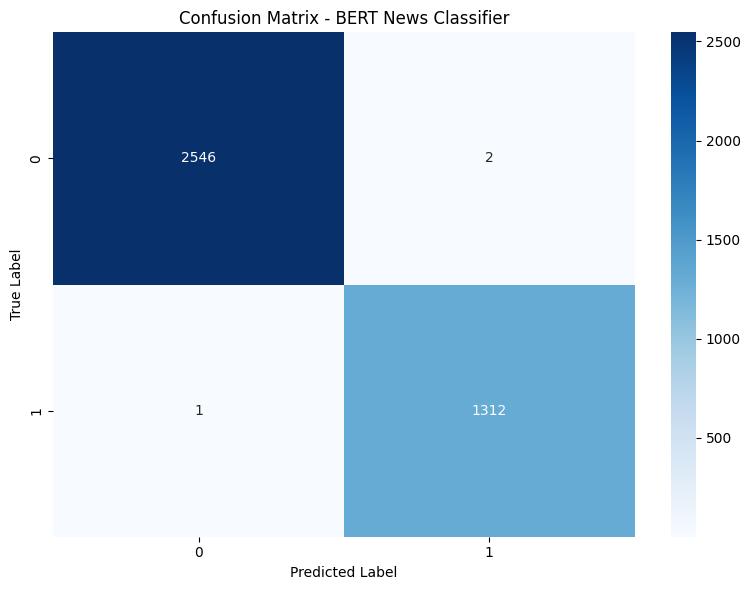


Cross-Validation Fold 5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3
Validation loss: 0.0041
Average training loss: 0.0202

Epoch 2/3
Validation loss: 0.0025
Average training loss: 0.0021

Epoch 3/3
Validation loss: 0.0028
Average training loss: 0.0005


<ipython-input-6-8fa15b1d254d>:351: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load('best_model.pt'))



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2548
           1       1.00      1.00      1.00      1313

    accuracy                           1.00      3861
   macro avg       1.00      1.00      1.00      3861
weighted avg       1.00      1.00      1.00      3861



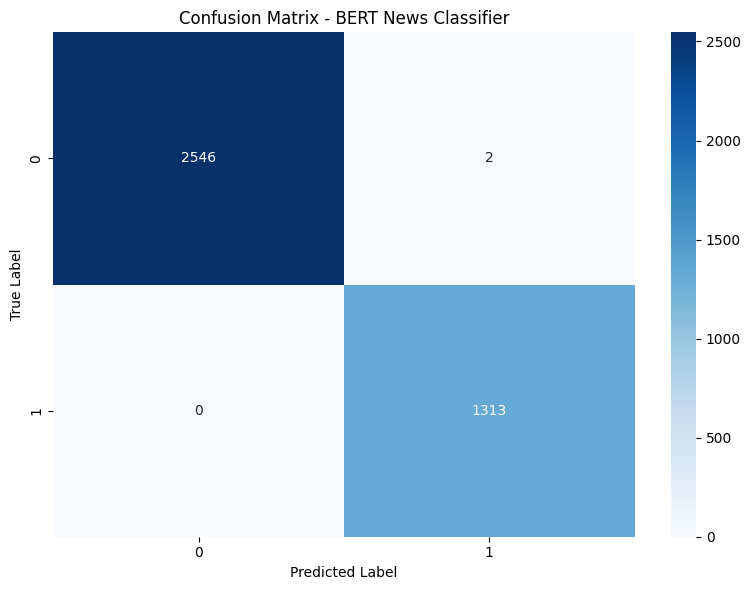


Cross-Validation Summary:
Accuracies: 0.9995 ± 0.0004
Precisions: 0.9995 ± 0.0004
Recalls: 0.9995 ± 0.0004
F1_scores: 0.9995 ± 0.0004


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Final Model Training ---

Epoch 1/3
Average training loss: 0.0164

Epoch 2/3
Average training loss: 0.0032

Epoch 3/3
Average training loss: 0.0000

--- Final Model Evaluation ---

Classification Report:
              precision    recall  f1-score   support

           0       0.34      1.00      0.51      4626
           1       1.00      0.38      0.56     14630

    accuracy                           0.53     19256
   macro avg       0.67      0.69      0.53     19256
weighted avg       0.84      0.53      0.54     19256



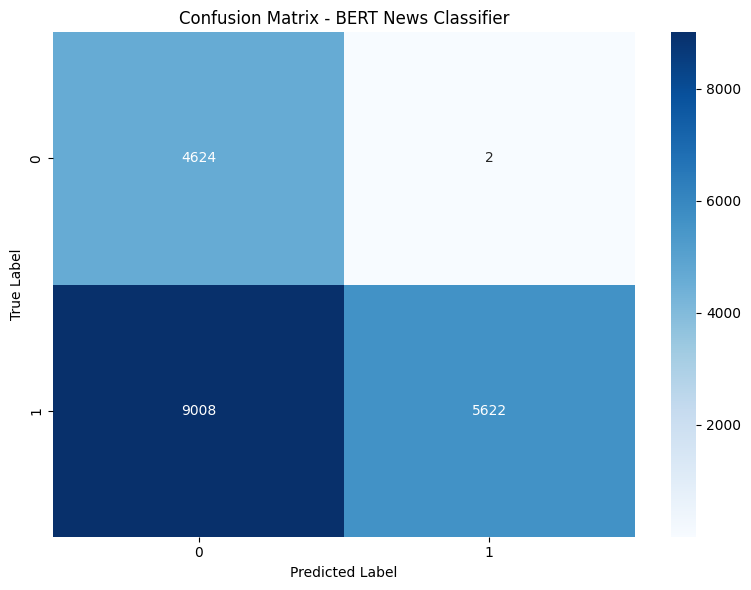


Final Model Performance Summary:
Accuracy: 0.5321
Precision: 0.8410
Recall: 0.5321
F1 Score: 0.5435


In [6]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support
)
import matplotlib.pyplot as plt
import seaborn as sns

class TemporalBertClassifier:
    def __init__(self,
                 model_name='bert-base-uncased',
                 max_length=512,
                 train_cutoff_date=None,
                 test_start_date=None,
                 batch_size=16,
                 learning_rate=2e-5,
                 weight_decay=0.01,  # L2 regularization
                 epochs=3,
                 early_stopping_patience=2,
                 random_state=42):
        """
        Initialize BERT-based Temporal News Classifier with advanced regularization

        Args:
            model_name (str): Pre-trained BERT model to use
            max_length (int): Maximum sequence length
            train_cutoff_date (str or datetime): Date for training data cutoff
            test_start_date (str or datetime): Date for test data start
            batch_size (int): Training batch size
            learning_rate (float): Learning rate for fine-tuning
            weight_decay (float): L2 regularization strength
            epochs (int): Maximum number of training epochs
            early_stopping_patience (int): Epochs to wait for improvement
            random_state (int): Random seed for reproducibility
        """
        # Set random seeds for reproducibility
        self.random_state = random_state
        np.random.seed(random_state)
        torch.manual_seed(random_state)

        # Model and tokenizer
        self.model_name = model_name
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=2,  # Binary classification
            output_attentions=False,
            output_hidden_states=False
        )

        # Training hyperparameters
        self.max_length = max_length
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.early_stopping_patience = early_stopping_patience

        # Temporal split parameters
        self.train_cutoff_date = train_cutoff_date
        self.test_start_date = test_start_date

        # Device configuration
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        self.model.to(self.device)

    class NewsDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, max_length):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_length = max_length

        def __len__(self):
            return len(self.texts)

        def __getitem__(self, idx):
            # Tokenize text
            encoding = self.tokenizer(
                self.texts[idx],
                return_tensors='pt',
                max_length=self.max_length,
                padding='max_length',
                truncation=True
            )

            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'labels': torch.tensor(self.labels[idx], dtype=torch.long)
            }

    def prepare_temporal_data(self, true_path, fake_path, date_column='date'):
        """
        Prepare dataset using temporal splitting

        Args:
            true_path (str): Path to true news CSV
            fake_path (str): Path to fake news CSV
            date_column (str): Name of the date column in the dataframes

        Returns:
            tuple: Training and testing dataframes
        """
        print("Loading datasets...")
        # Read datasets
        true_df = pd.read_csv(true_path, parse_dates=[date_column])
        fake_df = pd.read_csv(fake_path, parse_dates=[date_column])

        # Combine and label datasets
        true_df['label'] = 1
        fake_df['label'] = 0
        combined_df = pd.concat([true_df, fake_df], ignore_index=True)

        # Sort by date
        combined_df.sort_values(by=date_column, inplace=True)

        # Determine cutoff dates if not provided
        if self.train_cutoff_date is None:
            self.train_cutoff_date = combined_df[date_column].quantile(0.5)

        if self.test_start_date is None:
            self.test_start_date = self.train_cutoff_date + pd.Timedelta(days=1)

        # Split into training and testing sets based on date
        train_df = combined_df[combined_df[date_column] <= self.train_cutoff_date]
        test_df = combined_df[combined_df[date_column] >= self.test_start_date]

        print("\nTemporal Split Details:")
        print(f"Train period: up to {self.train_cutoff_date}")
        print(f"Test period: from {self.test_start_date}")

        print("\nDataset Composition:")
        print(f"Training True News: {len(train_df[train_df['label'] == 1])}")
        print(f"Training Fake News: {len(train_df[train_df['label'] == 0])}")
        print(f"Testing True News: {len(test_df[test_df['label'] == 1])}")
        print(f"Testing Fake News: {len(test_df[test_df['label'] == 0])}")

        return train_df, test_df

    def cross_validate(self, train_df, n_splits=5):
        """
        Perform cross-validation

        Args:
            train_df (DataFrame): Training dataframe
            n_splits (int): Number of cross-validation folds

        Returns:
            dict: Cross-validation results
        """
        # Stratified K-Fold
        skf = StratifiedKFold(
            n_splits=n_splits,
            shuffle=True,
            random_state=self.random_state
        )

        cv_results = {
            'accuracies': [],
            'precisions': [],
            'recalls': [],
            'f1_scores': []
        }

        # Perform cross-validation
        for fold, (train_idx, val_idx) in enumerate(
            skf.split(train_df['text'], train_df['label']), 1
        ):
            print(f"\nCross-Validation Fold {fold}")

            # Split data
            train_subset = train_df.iloc[train_idx]
            val_subset = train_df.iloc[val_idx]

            # Create datasets
            train_dataset = self.NewsDataset(
                texts=train_subset['text'].tolist(),
                labels=train_subset['label'].tolist(),
                tokenizer=self.tokenizer,
                max_length=self.max_length
            )

            val_dataset = self.NewsDataset(
                texts=val_subset['text'].tolist(),
                labels=val_subset['label'].tolist(),
                tokenizer=self.tokenizer,
                max_length=self.max_length
            )

            # Train model
            self._reset_model()
            best_val_loss = self.train(
                train_dataset,
                val_dataset,
                is_cross_validation=True
            )

            # Evaluate
            results = self.evaluate(val_dataset)

            # Store results
            cv_results['accuracies'].append(results['accuracy'])
            cv_results['precisions'].append(results['precision'])
            cv_results['recalls'].append(results['recall'])
            cv_results['f1_scores'].append(results['f1_score'])

        # Print cross-validation summary
        print("\nCross-Validation Summary:")
        for metric, values in cv_results.items():
            print(f"{metric.capitalize()}: {np.mean(values):.4f} ± {np.std(values):.4f}")

        return cv_results

    def _reset_model(self):
        """
        Reset the model to initial state
        Useful for cross-validation and multiple training runs
        """
        # Reinitialize the model
        self.model = BertForSequenceClassification.from_pretrained(
            self.model_name,
            num_labels=2,
            output_attentions=False,
            output_hidden_states=False
        )
        self.model.to(self.device)

    def train(self, train_dataset, val_dataset=None, is_cross_validation=False):
        """
        Train BERT model with early stopping

        Args:
            train_dataset (Dataset): Training dataset
            val_dataset (Dataset, optional): Validation dataset
            is_cross_validation (bool): Flag for cross-validation mode

        Returns:
            float: Best validation loss
        """
        # Create data loaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True
        )

        val_loader = None
        if val_dataset:
            val_loader = DataLoader(
                val_dataset,
                batch_size=self.batch_size,
                shuffle=False
            )

        # Prepare optimizer with weight decay (L2 regularization)
        optimizer = AdamW(
            self.model.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay  # L2 regularization
        )

        total_steps = len(train_loader) * self.epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )

        # Early stopping variables
        best_val_loss = float('inf')
        patience_counter = 0

        # Training loop
        for epoch in range(self.epochs):
            # Training mode
            self.model.train()
            total_train_loss = 0

            print(f"\nEpoch {epoch+1}/{self.epochs}")

            for batch in train_loader:
                # Move batch to device
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                # Zero gradients
                self.model.zero_grad()

                # Forward pass
                outputs = self.model(
                    input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                loss = outputs.loss
                total_train_loss += loss.item()

                # Backward pass
                loss.backward()

                # Clip gradients
                torch.nn.utils.clip_grad_norm_(
                    self.model.parameters(),
                    1.0
                )

                # Update parameters
                optimizer.step()
                scheduler.step()

            # Validation phase
            if val_loader:
                val_loss = self._validate(val_loader)

                # Early stopping check
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    # Save best model
                    torch.save(self.model.state_dict(), 'best_model.pt')
                else:
                    patience_counter += 1

                # Early stopping
                if patience_counter >= self.early_stopping_patience:
                    print(f"\nEarly stopping triggered after {epoch+1} epochs")
                    break

            # Print average training loss
            avg_train_loss = total_train_loss / len(train_loader)
            print(f"Average training loss: {avg_train_loss:.4f}")

        # Load best model if validation was used
        if val_loader:
            self.model.load_state_dict(torch.load('best_model.pt'))

        return best_val_loss

    def _validate(self, val_loader):
        """
        Validate the model

        Args:
            val_loader (DataLoader): Validation data loader

        Returns:
            float: Average validation loss
        """
        self.model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(
                    input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                total_val_loss += outputs.loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        print(f"Validation loss: {avg_val_loss:.4f}")
        return avg_val_loss

    def evaluate(self, test_dataset):
        """
        Evaluate the model on test dataset

        Args:
            test_dataset (Dataset): Testing dataset

        Returns:
            dict: Evaluation metrics
        """
        # Create data loader
        test_loader = DataLoader(
            test_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )

        # Evaluation mode
        self.model.eval()

        # Prediction containers
        true_labels = []
        predictions = []

        # Disable gradient calculations
        with torch.no_grad():
            for batch in test_loader:
                # Move batch to device
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].cpu().numpy()

                # Forward pass
                outputs = self.model(
                    input_ids,
                    attention_mask=attention_mask
                )

                # Get predictions
                _, preds = torch.max(outputs.logits, dim=1)
                preds = preds.cpu().numpy()

                # Collect results
                true_labels.extend(labels)
                predictions.extend(preds)

        # Compute metrics
        accuracy = accuracy_score(true_labels, predictions)
        precision, recall, f1_score, _ = precision_recall_fscore_support(
            true_labels, predictions, average='weighted'
        )

        # Confusion matrix
        cm = confusion_matrix(true_labels, predictions)

        # Print classification report
        print("\nClassification Report:")
        print(classification_report(true_labels, predictions))

        # Visualize results
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix - BERT News Classifier')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()

        # Return results dictionary
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'confusion_matrix': cm
        }

def main():
    # Initialize BERT Classifier with enhanced regularization
    bert_classifier = TemporalBertClassifier(
        model_name='bert-base-uncased',
        max_length=512,
        batch_size=16,  # Adjust based on your GPU memory
        learning_rate=2e-5,
        weight_decay=0.01,  # L2 regularization
        epochs=3,
        early_stopping_patience=2
    )

    # Paths to your CSV files
    true_news_path = 'processed_true.csv'
    fake_news_path = 'processed_fake.csv'

    try:
        # Prepare temporal data
        train_df, test_df = bert_classifier.prepare_temporal_data(
            true_news_path,
            fake_news_path,
            date_column='date'
        )

        # Perform cross-validation
        print("\n--- Cross-Validation ---")
        cv_results = bert_classifier.cross_validate(train_df, n_splits=5)

        # Prepare final training and testing datasets
        train_dataset = bert_classifier.NewsDataset(
            texts=train_df['text'].tolist(),
            labels=train_df['label'].tolist(),
            tokenizer=bert_classifier.tokenizer,
            max_length=bert_classifier.max_length
        )

        test_dataset = bert_classifier.NewsDataset(
            texts=test_df['text'].tolist(),
            labels=test_df['label'].tolist(),
            tokenizer=bert_classifier.tokenizer,
            max_length=bert_classifier.max_length
        )

        # Reset model to initial state
        bert_classifier._reset_model()

        # Train on full training set
        print("\n--- Final Model Training ---")
        bert_classifier.train(train_dataset)

        # Evaluate on test set
        print("\n--- Final Model Evaluation ---")
        final_results = bert_classifier.evaluate(test_dataset)

        # Print final results summary
        print("\nFinal Model Performance Summary:")
        print(f"Accuracy: {final_results['accuracy']:.4f}")
        print(f"Precision: {final_results['precision']:.4f}")
        print(f"Recall: {final_results['recall']:.4f}")
        print(f"F1 Score: {final_results['f1_score']:.4f}")

    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

fixing class imbalance


--- Weighted Loss Balancing ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda
Loading datasets with weighted_loss balancing...

Dataset Composition:
Training True News: 6564
Training Fake News: 12743
Testing True News: 14630
Testing Fake News: 4626

Epoch 1/3
Average training loss: 0.0238

Epoch 2/3
Average training loss: 0.0011

Epoch 3/3
Average training loss: 0.0000

Classification Report:
              precision    recall  f1-score   support

           0       0.34      1.00      0.50      4626
           1       1.00      0.37      0.54     14630

    accuracy                           0.52     19256
   macro avg       0.67      0.69      0.52     19256
weighted avg       0.84      0.52      0.53     19256



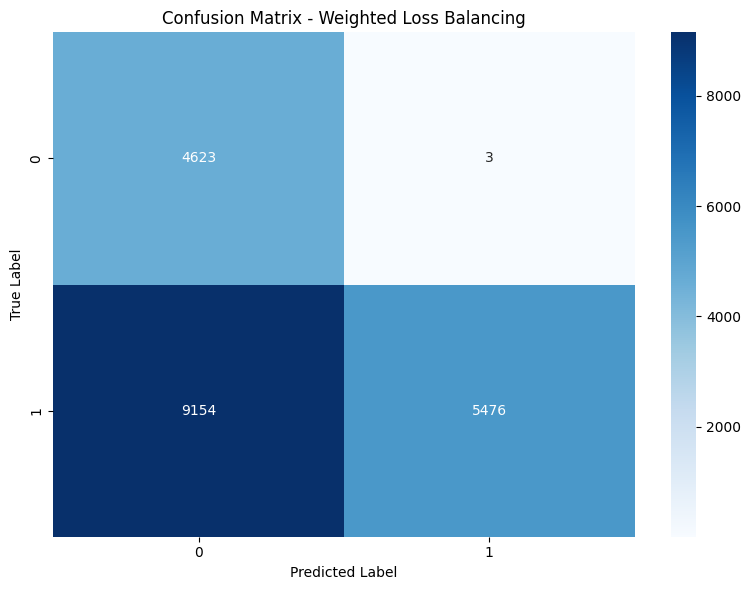


--- Oversample Balancing ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda
Loading datasets with oversample balancing...

Dataset Composition:
Training True News: 12743
Training Fake News: 12743
Testing True News: 14630
Testing Fake News: 4626

Epoch 1/3
Average training loss: 0.0159

Epoch 2/3
Average training loss: 0.0009

Epoch 3/3
Average training loss: 0.0002

Classification Report:
              precision    recall  f1-score   support

           0       0.34      1.00      0.51      4626
           1       1.00      0.38      0.56     14630

    accuracy                           0.53     19256
   macro avg       0.67      0.69      0.53     19256
weighted avg       0.84      0.53      0.54     19256



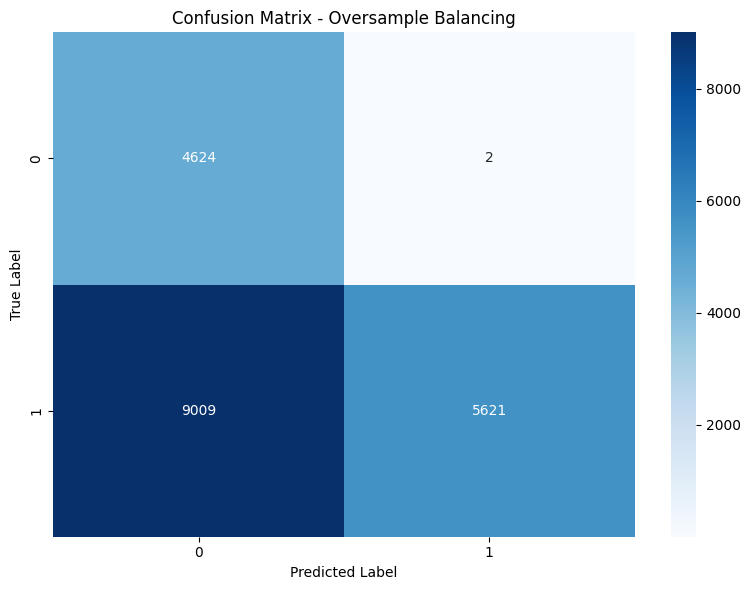


--- Undersample Balancing ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda
Loading datasets with undersample balancing...

Dataset Composition:
Training True News: 6564
Training Fake News: 6564
Testing True News: 14630
Testing Fake News: 4626

Epoch 1/3
Average training loss: 0.0236

Epoch 2/3
Average training loss: 0.0015

Epoch 3/3
Average training loss: 0.0003


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support
)
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

class ImbalancedBertClassifier:
    def __init__(self,
                 model_name='bert-base-uncased',
                 max_length=512,
                 train_cutoff_date=None,
                 test_start_date=None,
                 batch_size=16,
                 learning_rate=2e-5,
                 weight_decay=0.01,
                 epochs=3,
                 balance_method='weighted_loss',
                 random_state=42):
        """
        Initialize BERT-based Classifier with class imbalance handling

        Args:
            balance_method (str): Method to handle class imbalance
                Options:
                - 'weighted_loss': Use class weights
                - 'oversample': Oversample minority class
                - 'undersample': Undersample majority class
        """
        # Set random seeds
        self.random_state = random_state
        np.random.seed(random_state)
        torch.manual_seed(random_state)

        # Model and tokenizer
        self.model_name = model_name
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=2,
            output_attentions=False,
            output_hidden_states=False
        )

        # Training parameters
        self.max_length = max_length
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.epochs = epochs

        # Class balancing method
        self.balance_method = balance_method

        # Temporal split parameters
        self.train_cutoff_date = train_cutoff_date
        self.test_start_date = test_start_date

        # Device configuration
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        self.model.to(self.device)

    class NewsDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, max_length):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_length = max_length

        def __len__(self):
            return len(self.texts)

        def __getitem__(self, idx):
            encoding = self.tokenizer(
                self.texts[idx],
                return_tensors='pt',
                max_length=self.max_length,
                padding='max_length',
                truncation=True
            )

            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'labels': torch.tensor(self.labels[idx], dtype=torch.long)
            }

    def prepare_balanced_data(self, true_path, fake_path, date_column='date'):
        """
        Prepare dataset with different balancing techniques

        Returns:
            tuple: Training and testing dataframes
        """
        print(f"Loading datasets with {self.balance_method} balancing...")
        # Read datasets
        true_df = pd.read_csv(true_path, parse_dates=[date_column])
        fake_df = pd.read_csv(fake_path, parse_dates=[date_column])

        # Combine and label datasets
        true_df['label'] = 1
        fake_df['label'] = 0
        combined_df = pd.concat([true_df, fake_df], ignore_index=True)

        # Sort by date
        combined_df.sort_values(by=date_column, inplace=True)

        # Determine cutoff dates
        if self.train_cutoff_date is None:
            self.train_cutoff_date = combined_df[date_column].quantile(0.5)

        if self.test_start_date is None:
            self.test_start_date = self.train_cutoff_date + pd.Timedelta(days=1)

        # Split into training and testing sets
        train_df = combined_df[combined_df[date_column] <= self.train_cutoff_date]
        test_df = combined_df[combined_df[date_column] >= self.test_start_date]

        # Apply balancing technique to training data
        if self.balance_method == 'oversample':
            # Identify minority and majority classes
            minority = train_df[train_df['label'] == train_df['label'].value_counts().idxmin()]
            majority = train_df[train_df['label'] == train_df['label'].value_counts().idxmax()]

            # Oversample minority class
            minority_oversampled = resample(
                minority,
                replace=True,
                n_samples=len(majority),
                random_state=self.random_state
            )

            # Combine oversampled data
            train_df = pd.concat([majority, minority_oversampled])

        elif self.balance_method == 'undersample':
            # Identify minority and majority classes
            minority = train_df[train_df['label'] == train_df['label'].value_counts().idxmin()]
            majority = train_df[train_df['label'] == train_df['label'].value_counts().idxmax()]

            # Undersample majority class
            majority_undersampled = resample(
                majority,
                replace=False,
                n_samples=len(minority),
                random_state=self.random_state
            )

            # Combine undersampled data
            train_df = pd.concat([minority, majority_undersampled])

        print("\nDataset Composition:")
        print(f"Training True News: {len(train_df[train_df['label'] == 1])}")
        print(f"Training Fake News: {len(train_df[train_df['label'] == 0])}")
        print(f"Testing True News: {len(test_df[test_df['label'] == 1])}")
        print(f"Testing Fake News: {len(test_df[test_df['label'] == 0])}")

        return train_df, test_df

    def _compute_class_weights(self, labels):
        """
        Compute class weights for balanced loss
        """
        class_counts = np.bincount(labels)
        total_samples = len(labels)
        class_weights = total_samples / (len(class_counts) * class_counts)
        return torch.tensor(class_weights, dtype=torch.float).to(self.device)

    def train(self, train_dataset, val_dataset=None):
        """
        Train BERT model with class balancing
        """
        # Prepare data loaders
        if self.balance_method == 'weighted_loss':
            # Compute class weights
            labels = train_dataset.labels
            class_weights = self._compute_class_weights(labels)

            # Custom loss function with weights
            loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)

            train_loader = DataLoader(
                train_dataset,
                batch_size=self.batch_size,
                shuffle=True
            )
        elif self.balance_method in ['oversample', 'undersample']:
            # Create data loader (balanced by resampling)
            train_loader = DataLoader(
                train_dataset,
                batch_size=self.batch_size,
                shuffle=True
            )
        else:
            # Default training
            train_loader = DataLoader(
                train_dataset,
                batch_size=self.batch_size,
                shuffle=True
            )

        # Optimizer and scheduler
        optimizer = AdamW(
            self.model.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay
        )

        total_steps = len(train_loader) * self.epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )

        # Training loop
        self.model.train()
        for epoch in range(self.epochs):
            total_loss = 0
            print(f"\nEpoch {epoch+1}/{self.epochs}")

            for batch in train_loader:
                # Move batch to device
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                # Zero gradients
                self.model.zero_grad()

                # Forward pass
                outputs = self.model(
                    input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                # Compute loss
                if self.balance_method == 'weighted_loss':
                    # Custom loss with weights
                    loss = loss_fct(
                        outputs.logits.view(-1, self.model.config.num_labels),
                        labels
                    )
                else:
                    # Default loss
                    loss = outputs.loss

                total_loss += loss.item()

                # Backward pass
                loss.backward()

                # Clip gradients
                torch.nn.utils.clip_grad_norm_(
                    self.model.parameters(),
                    1.0
                )

                # Update parameters
                optimizer.step()
                scheduler.step()

            # Print average loss
            avg_loss = total_loss / len(train_loader)
            print(f"Average training loss: {avg_loss:.4f}")

    def evaluate(self, test_dataset):
        """
        Evaluate the model on test dataset
        """
        # Create data loader
        test_loader = DataLoader(
            test_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )

        # Evaluation mode
        self.model.eval()

        # Prediction containers
        true_labels = []
        predictions = []

        # Disable gradient calculations
        with torch.no_grad():
            for batch in test_loader:
                # Move batch to device
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].cpu().numpy()

                # Forward pass
                outputs = self.model(
                    input_ids,
                    attention_mask=attention_mask
                )

                # Get predictions
                _, preds = torch.max(outputs.logits, dim=1)
                preds = preds.cpu().numpy()

                # Collect results
                true_labels.extend(labels)
                predictions.extend(preds)

        # Compute metrics
        print("\nClassification Report:")
        print(classification_report(true_labels, predictions))

        # Confusion matrix
        cm = confusion_matrix(true_labels, predictions)

        # Visualize results
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {self.balance_method.replace("_", " ").title()} Balancing')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()

        return {
            'true_labels': true_labels,
            'predictions': predictions,
            'confusion_matrix': cm
        }

def main():
    # List of balancing methods to try
    balance_methods = [
        'weighted_loss',
        'oversample',
        'undersample'
    ]

    # Paths to CSV files
    true_news_path = 'processed_true.csv'
    fake_news_path = 'processed_fake.csv'

    # Store results for comparison
    all_results = {}

    # Try different balancing methods
    for method in balance_methods:
        print(f"\n--- {method.replace('_', ' ').title()} Balancing ---")

        # Initialize classifier with specific balancing method
        bert_classifier = ImbalancedBertClassifier(
            model_name='bert-base-uncased',
            max_length=512,
            batch_size=16,
            balance_method=method,
            learning_rate=2e-5,
            epochs=3
        )

        # Prepare balanced data
        train_df, test_df = bert_classifier.prepare_balanced_data(
            true_news_path,
            fake_news_path,
            date_column='date'
        )

        # Prepare datasets
        train_dataset = bert_classifier.NewsDataset(
            texts=train_df['text'].tolist(),
            labels=train_df['label'].tolist(),
            tokenizer=bert_classifier.tokenizer,
            max_length=bert_classifier.max_length
        )

        test_dataset = bert_classifier.NewsDataset(
            texts=test_df['text'].tolist(),
            labels=test_df['label'].tolist(),
            tokenizer=bert_classifier.tokenizer,
            max_length=bert_classifier.max_length
        )

        # Train the model
        bert_classifier.train(train_dataset)

        # Evaluate and store results
        all_results[method] = bert_classifier.evaluate(test_dataset)

if __name__ == "__main__":
    main()

In [8]:
class EnsembleBertClassifier:
    def __init__(self,
                 n_models=3,
                 model_name='bert-base-uncased',
                 max_length=512,
                 batch_size=16,
                 learning_rate=2e-5,
                 weight_decay=0.01,
                 epochs=3,
                 balance_method='weighted_loss'):
        """
        Initialize Ensemble BERT Classifier

        Args:
            n_models: Number of models in ensemble
            balance_method: Method to handle class imbalance
                Options: 'weighted_loss' or 'undersample'
        """
        self.n_models = n_models
        self.models = []
        self.base_seed = 42

        # Create multiple BERT classifiers with different seeds
        for i in range(n_models):
            classifier = ImbalancedBertClassifier(
                model_name=model_name,
                max_length=max_length,
                batch_size=batch_size,
                learning_rate=learning_rate,
                weight_decay=weight_decay,
                epochs=epochs,
                balance_method=balance_method,
                random_state=self.base_seed + i
            )
            self.models.append(classifier)

    def train(self, train_df, val_df=None):
        """Train all models in the ensemble"""
        for i, model in enumerate(self.models):
            print(f"\nTraining Model {i+1}/{self.n_models}")

            # Create datasets for current model
            train_dataset = model.NewsDataset(
                texts=train_df['text'].tolist(),
                labels=train_df['label'].tolist(),
                tokenizer=model.tokenizer,
                max_length=model.max_length
            )

            if val_df is not None:
                val_dataset = model.NewsDataset(
                    texts=val_df['text'].tolist(),
                    labels=val_df['label'].tolist(),
                    tokenizer=model.tokenizer,
                    max_length=model.max_length
                )
                model.train(train_dataset, val_dataset)
            else:
                model.train(train_dataset)

    def predict_proba(self, test_dataset):
        """Get probability predictions from all models"""
        all_probs = []

        for model in self.models:
            # Get probabilities from current model
            model.model.eval()
            probs = []

            test_loader = DataLoader(
                test_dataset,
                batch_size=model.batch_size,
                shuffle=False
            )

            with torch.no_grad():
                for batch in test_loader:
                    input_ids = batch['input_ids'].to(model.device)
                    attention_mask = batch['attention_mask'].to(model.device)

                    outputs = model.model(
                        input_ids,
                        attention_mask=attention_mask
                    )

                    # Get probabilities using softmax
                    batch_probs = torch.softmax(outputs.logits, dim=1)
                    probs.append(batch_probs.cpu().numpy())

            all_probs.append(np.concatenate(probs))

        # Average probabilities across models
        return np.mean(all_probs, axis=0)

    def evaluate(self, test_df):
        """Evaluate the ensemble"""
        # Create dataset
        test_dataset = self.models[0].NewsDataset(
            texts=test_df['text'].tolist(),
            labels=test_df['label'].tolist(),
            tokenizer=self.models[0].tokenizer,
            max_length=self.models[0].max_length
        )

        # Get ensemble predictions
        probs = self.predict_proba(test_dataset)
        predictions = np.argmax(probs, axis=1)
        true_labels = test_df['label'].values

        # Print metrics
        print("\nEnsemble Classification Report:")
        print(classification_report(true_labels, predictions))

        # Plot confusion matrix
        cm = confusion_matrix(true_labels, predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Ensemble Model Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()

        return {
            'true_labels': true_labels,
            'predictions': predictions,
            'probabilities': probs,
            'confusion_matrix': cm
        }

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda
Loading datasets with weighted_loss balancing...

Dataset Composition:
Training True News: 6564
Training Fake News: 12743
Testing True News: 14630
Testing Fake News: 4626

Training Model 1/3

Epoch 1/3
Average training loss: 0.0196

Epoch 2/3
Average training loss: 0.0032

Epoch 3/3
Average training loss: 0.0003

Training Model 2/3

Epoch 1/3
Average training loss: 0.0172

Epoch 2/3
Average training loss: 0.0011

Epoch 3/3
Average training loss: 0.0014

Training Model 3/3

Epoch 1/3
Average training loss: 0.0190

Epoch 2/3
Average training loss: 0.0024

Epoch 3/3
Average training loss: 0.0001

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.34      1.00      0.51      4626
           1       1.00      0.39      0.56     14630

    accuracy                           0.53     19256
   macro avg       0.67      0.69      0.53     19256
weighted avg       0.84      0.53      0.55     19256



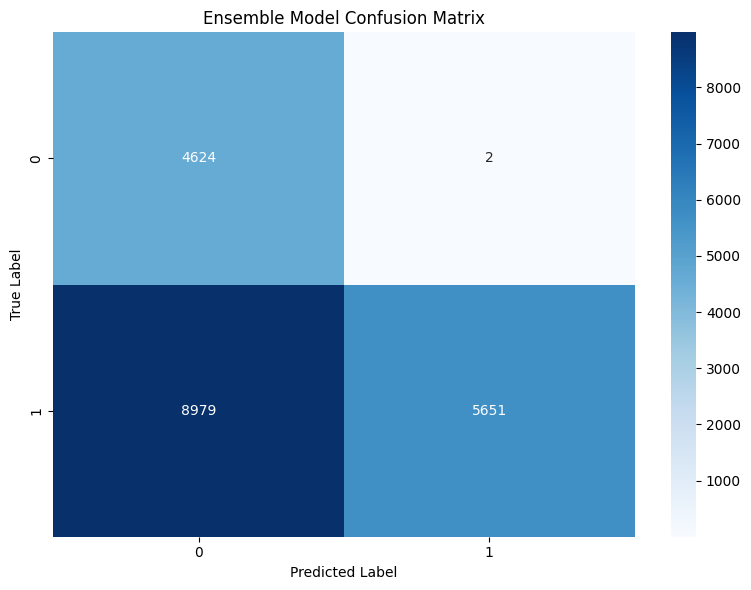

In [9]:
def main():
    # Paths to CSV files
    true_news_path = 'processed_true.csv'
    fake_news_path = 'processed_fake.csv'

    # Initialize ensemble classifier
    ensemble = EnsembleBertClassifier(
        n_models=3,  # Use 3 models in ensemble
        model_name='bert-base-uncased',
        max_length=512,
        batch_size=16,
        balance_method='weighted_loss',
        epochs=3
    )

    # Prepare data using the first model's data preparation method
    train_df, test_df = ensemble.models[0].prepare_balanced_data(
        true_news_path,
        fake_news_path,
        date_column='date'
    )

    # Train ensemble
    ensemble.train(train_df)

    # Evaluate ensemble
    results = ensemble.evaluate(test_df)

if __name__ == "__main__":
    main()

In [10]:
class ImprovedEnsembleBertClassifier:
    def __init__(self,
                 n_models=3,
                 model_name='bert-base-uncased',
                 max_length=512,
                 batch_size=16,
                 learning_rate=2e-5,
                 weight_decay=0.01,
                 epochs=3):
        """
        Initialize Improved Ensemble BERT Classifier with threshold optimization
        """
        self.n_models = n_models
        self.models = []
        self.base_seed = 42
        self.optimal_threshold = 0.5  # Will be tuned on validation data

        # Create multiple BERT classifiers with different seeds
        for i in range(n_models):
            classifier = ImbalancedBertClassifier(
                model_name=model_name,
                max_length=max_length,
                batch_size=batch_size,
                learning_rate=learning_rate,
                weight_decay=weight_decay,
                epochs=epochs,
                balance_method='weighted_loss',  # Using weighted loss with improved weights
                random_state=self.base_seed + i
            )
            self.models.append(classifier)

    def _compute_improved_class_weights(self, labels):
        """
        Compute class weights with improved balancing
        """
        class_counts = np.bincount(labels)
        total = len(labels)

        # Calculate weights inversely proportional to class frequencies
        # with additional scaling for minority class
        weights = total / (class_counts * 2.0)

        # Add extra weight to minority class
        minority_idx = np.argmin(class_counts)
        weights[minority_idx] *= 1.5

        # Normalize weights
        weights = weights / weights.sum() * 2.0

        return torch.tensor(weights, dtype=torch.float)

    def train(self, train_df, val_df):
        """Train all models in the ensemble with improved weighting"""
        for i, model in enumerate(self.models):
            print(f"\nTraining Model {i+1}/{self.n_models}")

            # Create datasets
            train_dataset = model.NewsDataset(
                texts=train_df['text'].tolist(),
                labels=train_df['label'].tolist(),
                tokenizer=model.tokenizer,
                max_length=model.max_length
            )

            val_dataset = model.NewsDataset(
                texts=val_df['text'].tolist(),
                labels=val_df['label'].tolist(),
                tokenizer=model.tokenizer,
                max_length=model.max_length
            )

            # Compute improved class weights
            class_weights = self._compute_improved_class_weights(train_df['label'].values)
            class_weights = class_weights.to(model.device)

            # Train with weighted loss
            model.model.train()
            optimizer = AdamW(model.model.parameters(), lr=model.learning_rate)

            for epoch in range(model.epochs):
                total_loss = 0
                train_loader = DataLoader(train_dataset, batch_size=model.batch_size, shuffle=True)

                for batch in train_loader:
                    input_ids = batch['input_ids'].to(model.device)
                    attention_mask = batch['attention_mask'].to(model.device)
                    labels = batch['labels'].to(model.device)

                    outputs = model.model(input_ids, attention_mask=attention_mask)

                    # Weighted loss
                    loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
                    loss = loss_fct(outputs.logits, labels)

                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()

                    total_loss += loss.item()

                avg_loss = total_loss / len(train_loader)
                print(f"Epoch {epoch+1}, Average loss: {avg_loss:.4f}")

        # Find optimal threshold using validation set
        self.optimal_threshold = self.find_optimal_threshold(val_df)
        print(f"\nOptimal threshold found: {self.optimal_threshold:.3f}")

    def predict_proba(self, test_dataset):
        """Get probability predictions from all models"""
        all_probs = []

        for model in self.models:
            model.model.eval()
            probs = []
            test_loader = DataLoader(test_dataset, batch_size=model.batch_size, shuffle=False)

            with torch.no_grad():
                for batch in test_loader:
                    input_ids = batch['input_ids'].to(model.device)
                    attention_mask = batch['attention_mask'].to(model.device)

                    outputs = model.model(input_ids, attention_mask=attention_mask)
                    batch_probs = torch.softmax(outputs.logits, dim=1)
                    probs.append(batch_probs.cpu().numpy())

            all_probs.append(np.concatenate(probs))

        return np.mean(all_probs, axis=0)

    def find_optimal_threshold(self, val_df):
        """Find threshold that maximizes F1 score"""
        val_dataset = self.models[0].NewsDataset(
            texts=val_df['text'].tolist(),
            labels=val_df['label'].tolist(),
            tokenizer=self.models[0].tokenizer,
            max_length=self.models[0].max_length
        )

        # Get probabilities on validation set
        probs = self.predict_proba(val_dataset)
        true_labels = val_df['label'].values

        # Try different thresholds
        best_f1 = 0
        best_threshold = 0.5
        thresholds = np.arange(0.2, 0.8, 0.02)

        for threshold in thresholds:
            predictions = (probs[:, 1] >= threshold).astype(int)
            f1 = f1_score(true_labels, predictions, average='macro')

            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

        return best_threshold

    def predict(self, test_dataset):
        """Get predictions using optimal threshold"""
        probs = self.predict_proba(test_dataset)
        predictions = (probs[:, 1] >= self.optimal_threshold).astype(int)
        return predictions

    def evaluate(self, test_df):
        """Evaluate the ensemble using optimal threshold"""
        test_dataset = self.models[0].NewsDataset(
            texts=test_df['text'].tolist(),
            labels=test_df['label'].tolist(),
            tokenizer=self.models[0].tokenizer,
            max_length=self.models[0].max_length
        )

        predictions = self.predict(test_dataset)
        true_labels = test_df['label'].values

        print("\nImproved Ensemble Classification Report:")
        print(classification_report(true_labels, predictions))

        cm = confusion_matrix(true_labels, predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Improved Ensemble Confusion Matrix (threshold={self.optimal_threshold:.3f})')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()

        return {
            'true_labels': true_labels,
            'predictions': predictions,
            'threshold': self.optimal_threshold,
            'confusion_matrix': cm
        }

In [ ]:
def main():
    # Paths to CSV files
    true_news_path = 'processed_true.csv'
    fake_news_path = 'processed_fake.csv'

    # Initialize improved ensemble classifier
    ensemble = ImprovedEnsembleBertClassifier(
        n_models=3,
        model_name='bert-base-uncased',
        max_length=512,
        batch_size=16,
        epochs=3
    )

    # Prepare data with train/val/test split
    classifier = ensemble.models[0]  # Use first model's data preparation
    train_val_df, test_df = classifier.prepare_balanced_data(
        true_news_path,
        fake_news_path,
        date_column='date'
    )

    # Split train into train and validation
    train_df = train_val_df.sample(frac=0.8, random_state=42)
    val_df = train_val_df.drop(train_df.index)

    # Train ensemble with validation data for threshold optimization
    ensemble.train(train_df, val_df)

    # Evaluate ensemble
    results = ensemble.evaluate(test_df)

if __name__ == "__main__":
    main()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda
Loading datasets with weighted_loss balancing...

Dataset Composition:
Training True News: 6564
Training Fake News: 12743
Testing True News: 14630
Testing Fake News: 4626

Training Model 1/3


In [ ]:
# Let's check the original files
for file_type in ['True', 'Fake']:
    print(f"\nChecking {file_type}.csv raw dates:")
    df = pd.read_csv(f'{folder_path}/{file_type}.csv')
    print("Sample dates:")
    print(df['date'].head())
    print("\nUnique date formats:")
    print(df['date'].unique()[:10])  # Show first 10 unique dates
    print(f"Total rows: {len(df)}")


Checking True.csv raw dates:
Sample dates:
0    December 31, 2017 
1    December 29, 2017 
2    December 31, 2017 
3    December 30, 2017 
4    December 29, 2017 
Name: date, dtype: object

Unique date formats:
['December 31, 2017 ' 'December 29, 2017 ' 'December 30, 2017 '
 'December 28, 2017 ' 'December 25, 2017 ' 'December 27, 2017 '
 'December 26, 2017 ' 'December 24, 2017 ' 'December 23, 2017 '
 'December 22, 2017 ']
Total rows: 21417

Checking Fake.csv raw dates:
Sample dates:
0    December 31, 2017
1    December 31, 2017
2    December 30, 2017
3    December 29, 2017
4    December 25, 2017
Name: date, dtype: object

Unique date formats:
['December 31, 2017' 'December 30, 2017' 'December 29, 2017'
 'December 25, 2017' 'December 23, 2017' 'December 22, 2017'
 'December 21, 2017' 'December 20, 2017' 'December 19, 2017'
 'December 17, 2017']
Total rows: 23436


In [ ]:
# Load the original Fake.csv
df = pd.read_csv(f'{folder_path}/Fake.csv')

# Try to convert dates and see which ones fail
df['date'] = df['date'].str.strip()
df['valid_date'] = pd.to_datetime(df['date'], format='%B %d, %Y', errors='coerce')

# Look at some examples of dates that couldn't be parsed
print("Sample problematic dates:")
print(df[df['valid_date'].isna()]['date'].head(10))

Sample problematic dates:
9050    Dec 31, 2017
9051    Dec 31, 2017
9052    Dec 31, 2017
9053    Dec 31, 2017
9054    Dec 30, 2017
9055    Dec 30, 2017
9056    Dec 30, 2017
9057    Dec 30, 2017
9058    Dec 30, 2017
9059    Dec 30, 2017
Name: date, dtype: object


In [ ]:
folder_path = '/content/drive/My Drive/fakenewsdetection'
TextPreprocessor.process_files(folder_path)


Processing True.csv...
Converting dates...
Removed 0 rows with invalid dates
Processing 21417 rows

Sample dates before processing:
0   2017-12-31
1   2017-12-29
2   2017-12-31
3   2017-12-30
4   2017-12-29
Name: date, dtype: datetime64[ns]
Removed 222 duplicates
Processing complete. Saved as /content/drive/My Drive/fakenewsdetection/True_processed.csv

Processing Fake.csv...
Converting dates...
Removed 0 rows with invalid dates
Processing 23436 rows

Sample dates before processing:
0   2017-12-31
1   2017-12-31
2   2017-12-30
3   2017-12-29
4   2017-12-25
Name: date, dtype: datetime64[ns]
Removed 5572 duplicates
Processing complete. Saved as /content/drive/My Drive/fakenewsdetection/Fake_processed.csv

Saved combined dataset to /content/drive/My Drive/fakenewsdetection/combined_processed.csv


dataloading

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from transformers import BertModel, BertTokenizer, AdamW
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import classification_report

def load_news_files(true_path, false_path):
    """Load and process real and fake news files with dates"""
    true_df = pd.read_csv(true_path)
    false_df = pd.read_csv(false_path)

    def process_texts(df):
        df['title'] = df['title'].fillna('')
        df['text'] = df['text'].fillna('')
        # Convert date strings to datetime
        df['date'] = pd.to_datetime(df['date'])
        # Combine title and text
        texts = df.apply(lambda row: f"{row['title']} | {row['text']}", axis=1).values
        return texts, df['date'].values

    # Process each dataset
    true_texts, true_dates = process_texts(true_df)
    false_texts, false_dates = process_texts(false_df)

    # Combine all data
    all_texts = np.concatenate([true_texts, false_texts])
    all_labels = np.concatenate([np.ones(len(true_texts)), np.zeros(len(false_texts))])
    all_dates = np.concatenate([true_dates, false_dates])

    return all_texts, all_labels, all_dates


In [ ]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
class BERTBinaryClassifier(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', dropout=0.5):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.linear1 = nn.Linear(self.bert.config.hidden_size, 256)
        self.linear2 = nn.Linear(256, 2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs[1]
        x = self.dropout1(pooled_output)
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        return self.linear2(x)

datasplit

train

#weight decay to penalize model from relying too heavily on specific feautures (i.e. Reuters writing patters)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch.nn as nn
from transformers import AdamW
import numpy as np
import torch

# Add this loss function definition
class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.15):
        super().__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (pred.size(-1) - 1))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

# Complete the training function
def train_model(model, train_loader, val_loader, tokenizer, device, epochs=5):
    optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
    criterion = LabelSmoothingLoss(smoothing=0.15)
    model = model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

    return model

evaluate

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

def evaluate_model(model, data_loader, device):
    """Evaluate the model with detailed diagnostics"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []  # Store raw probabilities

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            probs = torch.softmax(outputs, dim=1)  # Get probabilities
            _, preds = torch.max(outputs, dim=1)

            all_probs.extend(probs.cpu().numpy().tolist())
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    # Convert to numpy arrays for easier analysis
    all_probs = np.array(all_probs)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Basic metrics
    accuracy = accuracy_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Per-class F1 scores
    f1_true = f1_score(all_labels, all_preds, pos_label=1)
    f1_fake = f1_score(all_labels, all_preds, pos_label=0)

    # Probability distribution analysis
    true_probs = all_probs[all_labels == 1][:, 1]  # Prob of true for true articles
    fake_probs = all_probs[all_labels == 0][:, 1]  # Prob of true for fake articles

    # Print detailed analysis
    print("\nDetailed Analysis:")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nProbability Statistics for True Articles:")
    print(f"Mean: {np.mean(true_probs):.4f}")
    print(f"Std: {np.std(true_probs):.4f}")
    print(f"Min: {np.min(true_probs):.4f}")
    print(f"Max: {np.max(true_probs):.4f}")
    print("\nProbability Statistics for Fake Articles:")
    print(f"Mean: {np.mean(fake_probs):.4f}")
    print(f"Std: {np.std(fake_probs):.4f}")
    print(f"Min: {np.min(fake_probs):.4f}")
    print(f"Max: {np.max(fake_probs):.4f}")

    # Find examples with least confident predictions
    n_examples = 5
    true_least_confident = np.argsort(true_probs)[:n_examples]
    fake_least_confident = np.argsort(fake_probs)[:-n_examples-1:-1]

    print(f"\n{n_examples} Least Confident True Predictions (actual probabilities):")
    for idx in true_least_confident:
        print(f"Prob: {true_probs[idx]:.4f}")

    print(f"\n{n_examples} Least Confident Fake Predictions (actual probabilities):")
    for idx in fake_least_confident:
        print(f"Prob: {fake_probs[idx]:.4f}")

    return {
        'accuracy': accuracy,
        'f1_score_true': f1_true,
        'f1_score_fake': f1_fake,
        'confusion_matrix': conf_matrix,
        'true_probs_stats': {
            'mean': np.mean(true_probs),
            'std': np.std(true_probs),
            'min': np.min(true_probs),
            'max': np.max(true_probs)
        },
        'fake_probs_stats': {
            'mean': np.mean(fake_probs),
            'std': np.std(fake_probs),
            'min': np.min(fake_probs),
            'max': np.max(fake_probs)
        }
    }

In [ ]:
# def main_binary(k=1):
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     # Use BERT instead of GPT-2
#     tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#     # Prepare text and labels
#     texts, labels = load_news_files(true_path, false_path)
#     max_len = 512  # BERT's limit

#     # Initialize metrics storage
#     fold_metrics = {
#         'accuracy': [],
#         'f1_scores': [],
#         'precision': [],
#         'recall': []
#     }

#     # Perform k-fold cross validation
#     kfold = KFold(n_splits=k, shuffle=True, random_state=42)

#     for fold, (train_idx, val_idx) in enumerate(kfold.split(texts)):
#         print(f'\nFold {fold + 1}/{k}')

#         # Initialize model
#         model = BERTBinaryClassifier()
#         model.to(device)

#         # Split data
#         train_texts = [texts[i] for i in train_idx]
#         val_texts = [texts[i] for i in val_idx]
#         train_labels = [labels[i] for i in train_idx]
#         val_labels = [labels[i] for i in val_idx]

#         # Create datasets
#         train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_len)
#         val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_len)

#         # Create dataloaders
#         train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
#         val_loader = DataLoader(val_dataset, batch_size=16)

#         # Train and evaluate
#         metrics = train_model(
#             model,
#             train_loader,
#             val_loader,
#             device=device,
#             epochs=3
#         )

#         # Store metrics
#         fold_metrics['accuracy'].append(metrics['accuracy'])
#         fold_metrics['f1_scores'].append(metrics['f1_score'])
#         fold_metrics['precision'].append(metrics['precision'])
#         fold_metrics['recall'].append(metrics['recall'])

#         # Clean up
#         del model
#         torch.cuda.empty_cache()

#     # Print final results
#     print("\nFinal Metrics (mean ± std):")
#     for metric in fold_metrics:
#         mean_val = np.mean(fold_metrics[metric])
#         std_val = np.std(fold_metrics[metric])
#         print(f"{metric}: {mean_val:.4f} ± {std_val:.4f}")

#     return fold_metrics

main

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit  # Change from KFold to TimeSeriesSplit

if __name__ == "__main__":
    folder_path = '/content/drive/My Drive/fakenewsdetection'
    true_path = f'{folder_path}/True_processed.csv'
    false_path = f'{folder_path}/Fake_processed.csv'

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    try:
        # Load data with dates
        print("Loading data...")
        texts, labels, dates = load_news_files(true_path, false_path)  # Modified to include dates
        print(f"Loaded {len(texts)} texts")

        # Sort data by date
        sorted_idx = np.argsort(dates)
        texts = texts[sorted_idx]
        labels = labels[sorted_idx]
        dates = dates[sorted_idx]

        # Initialize time series cross-validation
        n_samples = len(texts)
        n_splits = 3

        # Calculate minimum sizes needed for 3 splits with gap
        test_size = n_samples // (n_splits + 1)  # Make test size smaller to accommodate splits and gap
        tscv = TimeSeriesSplit(
            n_splits=n_splits,
            test_size=test_size,
            gap=7
        )
        # Store metrics for each fold
        fold_metrics = {
            'accuracy': [],
            'f1_score': [],
            'precision': [],
            'recall': []
        }

        # Perform time series cross validation
        for fold, (train_idx, val_idx) in enumerate(tscv.split(texts)):
            print(f'\nFold {fold + 1}/{n_splits}')
            print(f"Training data from: {dates[train_idx[0]]} to {dates[train_idx[-1]]}")
            print(f"Validation data from: {dates[val_idx[0]]} to {dates[val_idx[-1]]}")

            # Initialize tokenizer and model with increased regularization
            print("Initializing tokenizer and model...")
            tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            model = BERTBinaryClassifier(dropout=0.5)  # Increased dropout
            model = model.to(device)

            # Split data for this fold
            train_texts = [texts[i] for i in train_idx]
            val_texts = [texts[i] for i in val_idx]
            train_labels = [labels[i] for i in train_idx]
            val_labels = [labels[i] for i in val_idx]

            # Create datasets and loaders
            print("Creating data splits...")
            train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer)
            val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer)

            train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=16)

            # Print class distribution for this fold
            train_label_dist = np.bincount(train_labels) / len(train_labels)
            val_label_dist = np.bincount(val_labels) / len(val_labels)
            print(f"Training class distribution: {train_label_dist}")
            print(f"Validation class distribution: {val_label_dist}")

            # Train model
            print(f"Starting training for fold {fold + 1}...")
            metrics = train_model(
                model=model,
                train_loader=train_loader,
                tokenizer=tokenizer,
                val_loader=val_loader,
                device=device,
                epochs=5  # Increased epochs due to stronger regularization
            )

            # Evaluate on validation set
            metrics = evaluate_model(model, val_loader, device)

            # Store metrics for this fold
            for metric in metrics:
                fold_metrics[metric].append(metrics[metric])

            print(f"Fold {fold + 1} Results:")
            for metric, value in metrics.items():
                print(f"{metric}: {value:.4f}")

            # Clean up
            del model
            torch.cuda.empty_cache()

        # Print final results with more detailed analysis
        print("\nFinal Time Series Cross-Validation Results:")
        print("=========================================")
        for metric in fold_metrics:
            scores = fold_metrics[metric]
            mean_score = np.mean(scores)
            std_score = np.std(scores)
            print(f"\n{metric.capitalize()}:")
            print(f"Mean: {mean_score:.4f}")
            print(f"Std:  {std_score:.4f}")
            print(f"All Folds: {scores}")
            print(f"Trend across folds: {' -> '.join([f'{score:.4f}' for score in scores])}")

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise e  # Re-raise the exception to see the full traceback

Using device: cuda
Loading data...
Loaded 39059 texts

Fold 1/3
Training data from: 2015-03-31T00:00:00.000000000 to 2016-07-23T00:00:00.000000000
Validation data from: 2016-07-23T00:00:00.000000000 to 2017-03-20T00:00:00.000000000
Initializing tokenizer and model...
Creating data splits...
Training class distribution: [0.73237705 0.26762295]
Validation class distribution: [0.6087669 0.3912331]
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5, Loss: 0.4504
Epoch 2/5, Loss: 0.4310
Epoch 3/5, Loss: 0.4294
Epoch 4/5, Loss: 0.4280
Epoch 5/5, Loss: 0.4272

Detailed Analysis:
Confusion Matrix:
[[5943    1]
 [   3 3817]]

Probability Statistics for True Articles:
Mean: 0.8379
Std: 0.0185
Min: 0.1739
Max: 0.8435

Probability Statistics for Fake Articles:
Mean: 0.1702
Std: 0.0056
Min: 0.1591
Max: 0.5233

5 Least Confident True Predictions (actual probabilities):
Prob: 0.1739
Prob: 0.2166
Prob: 0.2302
Prob: 0.6486
Prob: 0.6677

5 Least Confident Fake Predictions (actual probabilities):
Prob: 0.5233
Prob: 0.2105
Prob: 0.2038
Prob: 0.2015
Prob: 0.2015
An error occurred: 'f1_score_true'


KeyError: 'f1_score_true'

feauture importance

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, AdamW
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

class BERTBinaryClassifier(torch.nn.Module):
    def __init__(self, dropout=0.5):
        super(BERTBinaryClassifier, self).__init__()
        from transformers import BertModel
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = torch.nn.Dropout(dropout)
        self.linear = torch.nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        dropout_output = self.dropout(pooled_output)
        return self.linear(dropout_output)

def load_news_files(true_path, false_path):
    true_df = pd.read_csv(true_path)
    false_df = pd.read_csv(false_path)

    texts = np.concatenate([true_df['text'].values, false_df['text'].values])
    labels = np.concatenate([np.ones(len(true_df)), np.zeros(len(false_df))])
    dates = pd.concat([true_df['date'], false_df['date']]).values
    dates = pd.to_datetime(dates)

    return texts, labels, dates

def analyze_model_patterns(model, val_loader, tokenizer, device):
    """Combined analysis of feature importance and pattern testing"""
    print("\n=== Feature Importance Analysis ===")
    important_tokens = {0: {}, 1: {}}  # For each class

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            probs = torch.softmax(outputs, dim=1)

            for i in range(len(input_ids)):
                tokens = tokenizer.convert_ids_to_tokens(input_ids[i])
                label = labels[i].item()
                prob = probs[i][label].item()

                if prob > 0.9:
                    for token in tokens:
                        if token not in ['[PAD]', '[CLS]', '[SEP]', '[UNK]']:
                            important_tokens[label][token] = important_tokens[label].get(token, 0) + 1

    # Print top tokens for each class
    for label in [0, 1]:
        class_name = "True" if label == 1 else "Fake"
        print(f"\nTop 20 tokens for {class_name} news:")
        sorted_tokens = sorted(important_tokens[label].items(), key=lambda x: x[1], reverse=True)[:20]
        for token, count in sorted_tokens:
            print(f"{token}: {count}")

    print("\n=== Pattern Testing ===")
    test_cases = [
        "LONDON (Reuters) - Breaking news about economy",
        "Breaking news about economy",
        "News about economy from London",
        "(Reuters) - News about economy",
        "A news story about economy",
        "WASHINGTON - News about economy",
        "BEIJING, June 15 - News about economy",
        "LONDON - Reuters reports on economy",
        "Reuters: Latest news on economy",
        "Economic news from our correspondents"
    ]

    for text in test_cases:
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.softmax(outputs, dim=1)

        true_prob = probs[0][1].item()
        print(f"\nText: {text}")
        print(f"Probability of True: {true_prob:.4f}")
        print(f"Probability of Fake: {(1-true_prob):.4f}")

    return important_tokens

def train_model(model, train_loader, tokenizer, val_loader, device, epochs=5):
    optimizer = AdamW(model.parameters(), lr=2e-5)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}')

def evaluate_model(model, data_loader, device, tokenizer):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, dim=1)

            all_probs.extend(probs.cpu().numpy().tolist())
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    # Convert to numpy arrays
    all_probs = np.array(all_probs)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    # Print detailed analysis
    print("\nDetailed Analysis:")
    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

    true_probs = all_probs[all_labels == 1][:, 1]
    fake_probs = all_probs[all_labels == 0][:, 1]

    print("\nProbability Statistics:")
    print("True articles:")
    print(f"Mean: {np.mean(true_probs):.4f}")
    print(f"Std: {np.std(true_probs):.4f}")
    print(f"Min: {np.min(true_probs):.4f}")
    print(f"Max: {np.max(true_probs):.4f}")

    print("\nFake articles:")
    print(f"Mean: {np.mean(fake_probs):.4f}")
    print(f"Std: {np.std(fake_probs):.4f}")
    print(f"Min: {np.min(fake_probs):.4f}")
    print(f"Max: {np.max(fake_probs):.4f}")

    print("\nLeast Confident Predictions:")
    print("\n5 Least Confident True Predictions (actual probabilities):")
    true_least_confident = np.argsort(true_probs)[:5]
    for idx in true_least_confident:
        print(f"Prob: {true_probs[idx]:.4f}")

    print("\n5 Least Confident Fake Predictions (actual probabilities):")
    fake_least_confident = np.argsort(fake_probs)[:-6:-1]
    for idx in fake_least_confident:
        print(f"Prob: {fake_probs[idx]:.4f}")

    # Run pattern analysis
    print("\nRunning pattern analysis...")
    analyze_model_patterns(model, data_loader, tokenizer, device)

    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall
    }

if __name__ == "__main__":
    folder_path = '/content/drive/My Drive/fakenewsdetection'
    true_path = f'{folder_path}/True_processed.csv'
    false_path = f'{folder_path}/Fake_processed.csv'

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    try:
        print("Loading data...")
        texts, labels, dates = load_news_files(true_path, false_path)
        print(f"Loaded {len(texts)} texts")

        sorted_idx = np.argsort(dates)
        texts = texts[sorted_idx]
        labels = labels[sorted_idx]
        dates = dates[sorted_idx]

        n_samples = len(texts)
        n_splits = 3
        test_size = n_samples // (n_splits + 1)

        tscv = TimeSeriesSplit(
            n_splits=n_splits,
            test_size=test_size,
            gap=7
        )

        fold_metrics = {
            'accuracy': [],
            'f1_score': [],
            'precision': [],
            'recall': []
        }

        for fold, (train_idx, val_idx) in enumerate(tscv.split(texts)):
            print(f'\nFold {fold + 1}/{n_splits}')
            print(f"Training data from: {dates[train_idx[0]]} to {dates[train_idx[-1]]}")
            print(f"Validation data from: {dates[val_idx[0]]} to {dates[val_idx[-1]]}")

            print("Initializing tokenizer and model...")
            tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            model = BERTBinaryClassifier(dropout=0.5)
            model = model.to(device)

            train_texts = [texts[i] for i in train_idx]
            val_texts = [texts[i] for i in val_idx]
            train_labels = [labels[i] for i in train_idx]
            val_labels = [labels[i] for i in val_idx]

            print("Creating data splits...")
            train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer)
            val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer)

            train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=16)

            train_label_dist = np.bincount(train_labels) / len(train_labels)
            val_label_dist = np.bincount(val_labels) / len(val_labels)
            print(f"Training class distribution: {train_label_dist}")
            print(f"Validation class distribution: {val_label_dist}")

            print(f"Starting training for fold {fold + 1}...")
            train_model(
                model=model,
                train_loader=train_loader,
                tokenizer=tokenizer,
                val_loader=val_loader,
                device=device,
                epochs=5
            )

            metrics = evaluate_model(model, val_loader, device, tokenizer)

            for metric in metrics:
                fold_metrics[metric].append(metrics[metric])

            print(f"Fold {fold + 1} Results:")
            for metric, value in metrics.items():
                print(f"{metric}: {value:.4f}")

            del model
            torch.cuda.empty_cache()

        print("\nFinal Results:")
        print("==============")
        for metric in fold_metrics:
            scores = fold_metrics[metric]
            mean_score = np.mean(scores)
            std_score = np.std(scores)
            print(f"\n{metric.capitalize()}:")
            print(f"Mean: {mean_score:.4f}")
            print(f"Std:  {std_score:.4f}")
            print(f"All Folds: {scores}")

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise e

Using device: cuda
Loading data...
Loaded 39059 texts

Fold 1/3
Training data from: 2015-03-31 00:00:00 to 2016-07-23 00:00:00
Validation data from: 2016-07-23 00:00:00 to 2017-03-20 00:00:00
Initializing tokenizer and model...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Creating data splits...
Training class distribution: [0.73237705 0.26762295]
Validation class distribution: [0.6087669 0.3912331]
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5, Loss: 0.0336
Epoch 2/5, Loss: 0.0039
Epoch 3/5, Loss: 0.0032
Epoch 4/5, Loss: 0.0019
Epoch 5/5, Loss: 0.0010

Detailed Analysis:
Confusion Matrix:
[[5942    2]
 [   3 3817]]

Probability Statistics:
True articles:
Mean: 0.9993
Std: 0.0254
Min: 0.0038
Max: 1.0000

Fake articles:
Mean: 0.0006
Std: 0.0169
Min: 0.0000
Max: 0.9682

Least Confident Predictions:

5 Least Confident True Predictions (actual probabilities):
Prob: 0.0038
Prob: 0.0176
Prob: 0.2856
Prob: 0.9986
Prob: 0.9998

5 Least Confident Fake Predictions (actual probabilities):
Prob: 0.9682
Prob: 0.8730
Prob: 0.0288
Prob: 0.0082
Prob: 0.0046

Running pattern analysis...

=== Feature Importance Analysis ===

Top 20 tokens for Fake news:
,: 88909
the: 88877
.: 86776
to: 51955
and: 40600
of: 39325
a: 36925
that: 29928
in: 28407
s: 27941
trump: 25360
is: 21553
he: 17917
for: 16701
it: 16063
on: 15140
his: 12689
-: 12672
was: 11418
with: 11157

Top 20 tokens for True news:
.: 67523
the: 64702
,: 58650
to: 34689
of: 28309

TypeError: BERTBinaryClassifier.forward() got an unexpected keyword argument 'token_type_ids'